In [3]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters


In [5]:
# # Initialize Alpha Vantage API
# api_key_alpha = 'E6DCENI7HUDGSZRV'  # Replace with your Alpha Vantage API key
# ts = TimeSeries(key=api_key_alpha, output_format='pandas')

# # Fetch daily data for S&P 500 ETF (e.g., SPY)
# sp500_data, meta_data = ts.get_daily(symbol='SPY', outputsize='full')

# # Reset index to make 'Date' a column
# sp500_data.reset_index(inplace=True)

# # Rename columns to match previous code
# sp500_data.rename(columns={
#     'date': 'Date',
#     '1. open': 'Open',
#     '2. high': 'High',
#     '3. low': 'Low',
#     '4. close': 'Close',
#     '5. volume': 'Volume'
# }, inplace=True)

# # Convert 'Date' to datetime
# sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])

In [4]:
sp500_data = pd.read_csv('sp500_data.csv')
sp500_data

,Date,Open,High,Low,Close,Volume
0,2024-11-26,598.8000,601.3300,598.0700,600.6500,45621288.0
1,2024-11-25,599.5200,600.8600,595.2000,597.5300,42441393.0
2,2024-11-22,593.6600,596.1500,593.1525,595.5100,38226390.0
3,2024-11-21,593.4000,595.1200,587.4500,593.6700,46750285.0
4,2024-11-20,590.3800,590.7900,584.6300,590.5000,50032576.0
...,...,...,...,...,...,...
6304,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0
6305,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0
6306,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0
6307,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0


In [5]:
# Initialize FRED API
fred = Fred(api_key='a6d8760ec5aac045396d0e0b7039aec7')

# Define series IDs and their corresponding indicators
series_dict = {
    'DCOILWTICO': 'Crude Oil WTI Futures',
    'DFF': 'Federal Funds Rate',
    'DEXUSEU': 'USD/EUR Exchange Rate',
    'DEXUSUK': 'USD/GBP Exchange Rate',
    'DEXCHUS': 'USD/CHF Exchange Rate',
    'DEXNOUS': 'USD/NOK Exchange Rate',
    'DEXSIUS': 'USD/SGD Exchange Rate',
    'DEXUSAL': 'USD/AUD Exchange Rate',
    'DEXCHUS': 'USD/CNY Exchange Rate',
    'DEXJPUS': 'USD/JPY Exchange Rate',
    'DEXINUS': 'USD/INR Exchange Rate',
}

# Set observation period
start_date = '1999-11-01'
end_date = '2024-11-01'

# Initialize an empty DataFrame to store the data
data_frames = []

# Fetch each series separately and store in the list
for series_id, series_name in series_dict.items():
    try:
        # Fetch series
        series_data = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)
        
        # Convert to DataFrame and rename column
        series_df = series_data.to_frame(name=series_name)
        
        # Append to list
        data_frames.append(series_df)
    except Exception as e:
        print(f"Error fetching {series_name} ({series_id}): {e}")

# Concatenate all data frames on the date index
fred_df = pd.concat(data_frames, axis=1)

# Reset index to include the date as a column
fred_df = fred_df.reset_index().rename(columns={'index': 'Date'})

# Display the DataFrame
fred_df


,Date,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,USD/CNY Exchange Rate,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,USD/JPY Exchange Rate,USD/INR Exchange Rate
0,1999-11-01,22.44,5.38,1.0494,1.6404,8.2779,7.8770,1.6565,0.6382,104.19,43.51
1,1999-11-02,22.49,5.18,1.0506,1.6445,8.2781,7.8650,1.6645,0.6405,104.15,43.45
2,1999-11-03,22.59,5.21,1.0485,1.6440,8.2781,7.8825,1.6700,0.6437,105.00,43.46
3,1999-11-04,23.17,5.27,1.0440,1.6375,8.2780,7.9120,1.6665,0.6383,104.48,43.45
4,1999-11-05,22.93,5.14,1.0400,1.6205,8.2779,7.9260,1.6715,0.6385,106.33,43.45
...,...,...,...,...,...,...,...,...,...,...,...
9128,2024-10-28,67.65,4.83,1.0819,1.2981,7.1254,10.9866,1.3227,0.6587,153.21,84.05
9129,2024-10-29,67.48,4.83,1.0798,1.3005,7.1301,10.9651,1.3254,0.6557,153.47,84.04
9130,2024-10-30,68.91,4.83,1.0864,1.3012,7.1229,10.9397,1.3222,0.6584,153.15,84.07
9131,2024-10-31,69.58,4.83,1.0855,1.2856,7.1178,11.0315,1.3230,0.6550,152.35,84.06


In [6]:
# Initialize FRED API
fred2 = Fred(api_key='a6d8760ec5aac045396d0e0b7039aec7')

# Define series IDs and their corresponding indicators
series_dict = {
    'M1SL': 'M1 Money Supply',
    'M2SL': 'M2 Money Supply',
    'CPIAUCSL': 'Consumer Price Index (CPI)',
    'PPIACO': 'Producer Price Index (PPI)',
    'UNRATE': 'Unemployment Rate'
}

# Set observation period
start_date = '1999-11-01'
end_date = '2024-11-01'

# Initialize an empty DataFrame to store the data
data_frames = []

# Fetch each series separately and store in the list
for series_id, series_name in series_dict.items():
    try:
        # Fetch series
        series_data = fred2.get_series(series_id, observation_start=start_date, observation_end=end_date)
        
        # Convert to DataFrame and rename column
        series_df = series_data.to_frame(name=series_name)
        
        # Append to list
        data_frames.append(series_df)
    except Exception as e:
        print(f"Error fetching {series_name} ({series_id}): {e}")

# Concatenate all data frames on the date index
fred_df2 = pd.concat(data_frames, axis=1)

# Reset index to include the date as a column
fred_df2 = fred_df2.reset_index().rename(columns={'index': 'Date'})

# Display the DataFrame
fred_df2


,Date,M1 Money Supply,M2 Money Supply,Consumer Price Index (CPI),Producer Price Index (PPI),Unemployment Rate
0,1999-11-01,1110.7,4611.8,168.400,128.300,4.1
1,1999-12-01,1122.2,4639.3,168.800,127.800,4.0
2,2000-01-01,1122.1,4667.6,169.300,128.300,4.0
3,2000-02-01,1108.6,4680.9,170.000,129.800,4.1
4,2000-03-01,1107.5,4711.7,171.000,130.800,4.0
...,...,...,...,...,...,...
295,2024-06-01,18045.2,21020.1,313.049,255.914,4.1
296,2024-07-01,18031.8,21039.4,313.534,257.326,4.3
297,2024-08-01,18094.5,21141.3,314.121,255.394,4.2
298,2024-09-01,18152.6,21222.7,314.686,252.737,4.1


In [7]:
# Ensure 'Date' columns are in datetime format
sp500_data['Date'] = pd.to_datetime(sp500_data['Date'])
fred_df['Date'] = pd.to_datetime(fred_df['Date'])
fred_df2['Date'] = pd.to_datetime(fred_df2['Date'])

# Merge the tables on the 'Date' column
# Perform an outer join to preserve all dates across datasets
combined_df = pd.merge(sp500_data, fred_df, on='Date', how='outer')
combined_df = pd.merge(combined_df, fred_df2, on='Date', how='outer')

# Sort by 'Date' to ensure proper time-series alignment
combined_df.sort_values(by='Date', inplace=True)

# Reset the index for convenience
combined_df.reset_index(drop=True, inplace=True)

# Check data types
print("Data Types of Combined DataFrame:")
print(combined_df.dtypes)

# Display the first few rows of the combined dataset
combined_df.head()


Data Types of Combined DataFrame:
Date                          datetime64[ns]
Open                                 float64
High                                 float64
Low                                  float64
Close                                float64
Volume                               float64
Crude Oil WTI Futures                float64
Federal Funds Rate                   float64
USD/EUR Exchange Rate                float64
USD/GBP Exchange Rate                float64
USD/CNY Exchange Rate                float64
USD/NOK Exchange Rate                float64
USD/SGD Exchange Rate                float64
USD/AUD Exchange Rate                float64
USD/JPY Exchange Rate                float64
USD/INR Exchange Rate                float64
M1 Money Supply                      float64
M2 Money Supply                      float64
Consumer Price Index (CPI)           float64
Producer Price Index (PPI)           float64
Unemployment Rate                    float64
dtype: object


,Date,Open,High,Low,Close,Volume,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,...,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,USD/JPY Exchange Rate,USD/INR Exchange Rate,M1 Money Supply,M2 Money Supply,Consumer Price Index (CPI),Producer Price Index (PPI),Unemployment Rate
0,1999-11-01,136.5000,137.0000,135.5625,135.5625,4006500.0,22.44,5.38,1.0494,1.6404,...,7.8770,1.6565,0.6382,104.19,43.51,1110.7,4611.8,168.4,128.3,4.1
1,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0,22.49,5.18,1.0506,1.6445,...,7.8650,1.6645,0.6405,104.15,43.45,NaN,NaN,NaN,NaN,NaN
2,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0,22.59,5.21,1.0485,1.6440,...,7.8825,1.6700,0.6437,105.00,43.46,NaN,NaN,NaN,NaN,NaN
3,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0,23.17,5.27,1.0440,1.6375,...,7.9120,1.6665,0.6383,104.48,43.45,NaN,NaN,NaN,NaN,NaN
4,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0,22.93,5.14,1.0400,1.6205,...,7.9260,1.6715,0.6385,106.33,43.45,NaN,NaN,NaN,NaN,NaN


In [8]:
# Step 1: Check for duplicate dates in the combined dataset
duplicate_dates = combined_df[combined_df.duplicated(subset='Date', keep=False)]
if duplicate_dates.empty:
    print("No duplicate dates found after merging.")
else:
    print(f"Duplicate dates found:\n{duplicate_dates}")

# Step 2: Check for missing values after the merge
missing_summary = combined_df.isnull().sum()
print("\nMissing Value Summary (per column):")
print(missing_summary)

# Step 3: Count rows with missing values in any column
rows_with_missing = combined_df[combined_df.isnull().any(axis=1)]
print(f"\nNumber of rows with missing values: {len(rows_with_missing)}")

# Step 4: Validate row counts
print(f"\nOriginal row counts:")
print(f"sp500_data: {len(sp500_data)}")
print(f"fred_df: {len(fred_df)}")
print(f"fred_df2: {len(fred_df2)}")
print(f"Combined DataFrame: {len(combined_df)}")

# Step 5: Check for unmatched dates in each dataset
sp500_unmatched = sp500_data[~sp500_data['Date'].isin(combined_df['Date'])]
fred_unmatched = fred_df[~fred_df['Date'].isin(combined_df['Date'])]
fred2_unmatched = fred_df2[~fred_df2['Date'].isin(combined_df['Date'])]

print(f"\nUnmatched dates in sp500_data: {len(sp500_unmatched)}")
print(f"Unmatched dates in fred_df: {len(fred_unmatched)}")
print(f"Unmatched dates in fred_df2: {len(fred2_unmatched)}")


No duplicate dates found after merging.

Missing Value Summary (per column):
Date                             0
Open                          2841
High                          2841
Low                           2841
Close                         2841
Volume                        2841
Crude Oil WTI Futures         2876
Federal Funds Rate              17
USD/EUR Exchange Rate         2878
USD/GBP Exchange Rate         2878
USD/CNY Exchange Rate         2877
USD/NOK Exchange Rate         2878
USD/SGD Exchange Rate         2878
USD/AUD Exchange Rate         2878
USD/JPY Exchange Rate         2878
USD/INR Exchange Rate         2879
M1 Money Supply               8850
M2 Money Supply               8850
Consumer Price Index (CPI)    8850
Producer Price Index (PPI)    8850
Unemployment Rate             8850
dtype: int64

Number of rows with missing values: 8955

Original row counts:
sp500_data: 6309
fred_df: 9133
fred_df2: 300
Combined DataFrame: 9150

Unmatched dates in sp500_data: 0
Unmatch

In [9]:
combined_df

,Date,Open,High,Low,Close,Volume,Crude Oil WTI Futures,Federal Funds Rate,USD/EUR Exchange Rate,USD/GBP Exchange Rate,...,USD/NOK Exchange Rate,USD/SGD Exchange Rate,USD/AUD Exchange Rate,USD/JPY Exchange Rate,USD/INR Exchange Rate,M1 Money Supply,M2 Money Supply,Consumer Price Index (CPI),Producer Price Index (PPI),Unemployment Rate
0,1999-11-01,136.5000,137.0000,135.5625,135.5625,4006500.0,22.44,5.38,1.0494,1.6404,...,7.8770,1.6565,0.6382,104.19,43.51,1110.7,4611.8,168.4,128.3,4.1
1,1999-11-02,135.9687,137.2500,134.5937,134.5937,6516900.0,22.49,5.18,1.0506,1.6445,...,7.8650,1.6645,0.6405,104.15,43.45,NaN,NaN,NaN,NaN,NaN
2,1999-11-03,136.0000,136.3750,135.1250,135.5000,7222300.0,22.59,5.21,1.0485,1.6440,...,7.8825,1.6700,0.6437,105.00,43.46,NaN,NaN,NaN,NaN,NaN
3,1999-11-04,136.7500,137.3593,135.7656,136.5312,7907500.0,23.17,5.27,1.0440,1.6375,...,7.9120,1.6665,0.6383,104.48,43.45,NaN,NaN,NaN,NaN,NaN
4,1999-11-05,138.6250,139.1093,136.7812,137.8750,7431500.0,22.93,5.14,1.0400,1.6205,...,7.9260,1.6715,0.6385,106.33,43.45,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9145,2024-11-20,590.3800,590.7900,584.6300,590.5000,50032576.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9146,2024-11-21,593.4000,595.1200,587.4500,593.6700,46750285.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9147,2024-11-22,593.6600,596.1500,593.1525,595.5100,38226390.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9148,2024-11-25,599.5200,600.8600,595.2000,597.5300,42441393.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# Impute monthly data using forward fill
combined_df2 = combined_df.copy()
for column in combined_df.columns:
    combined_df[column] = combined_df[column].ffill()


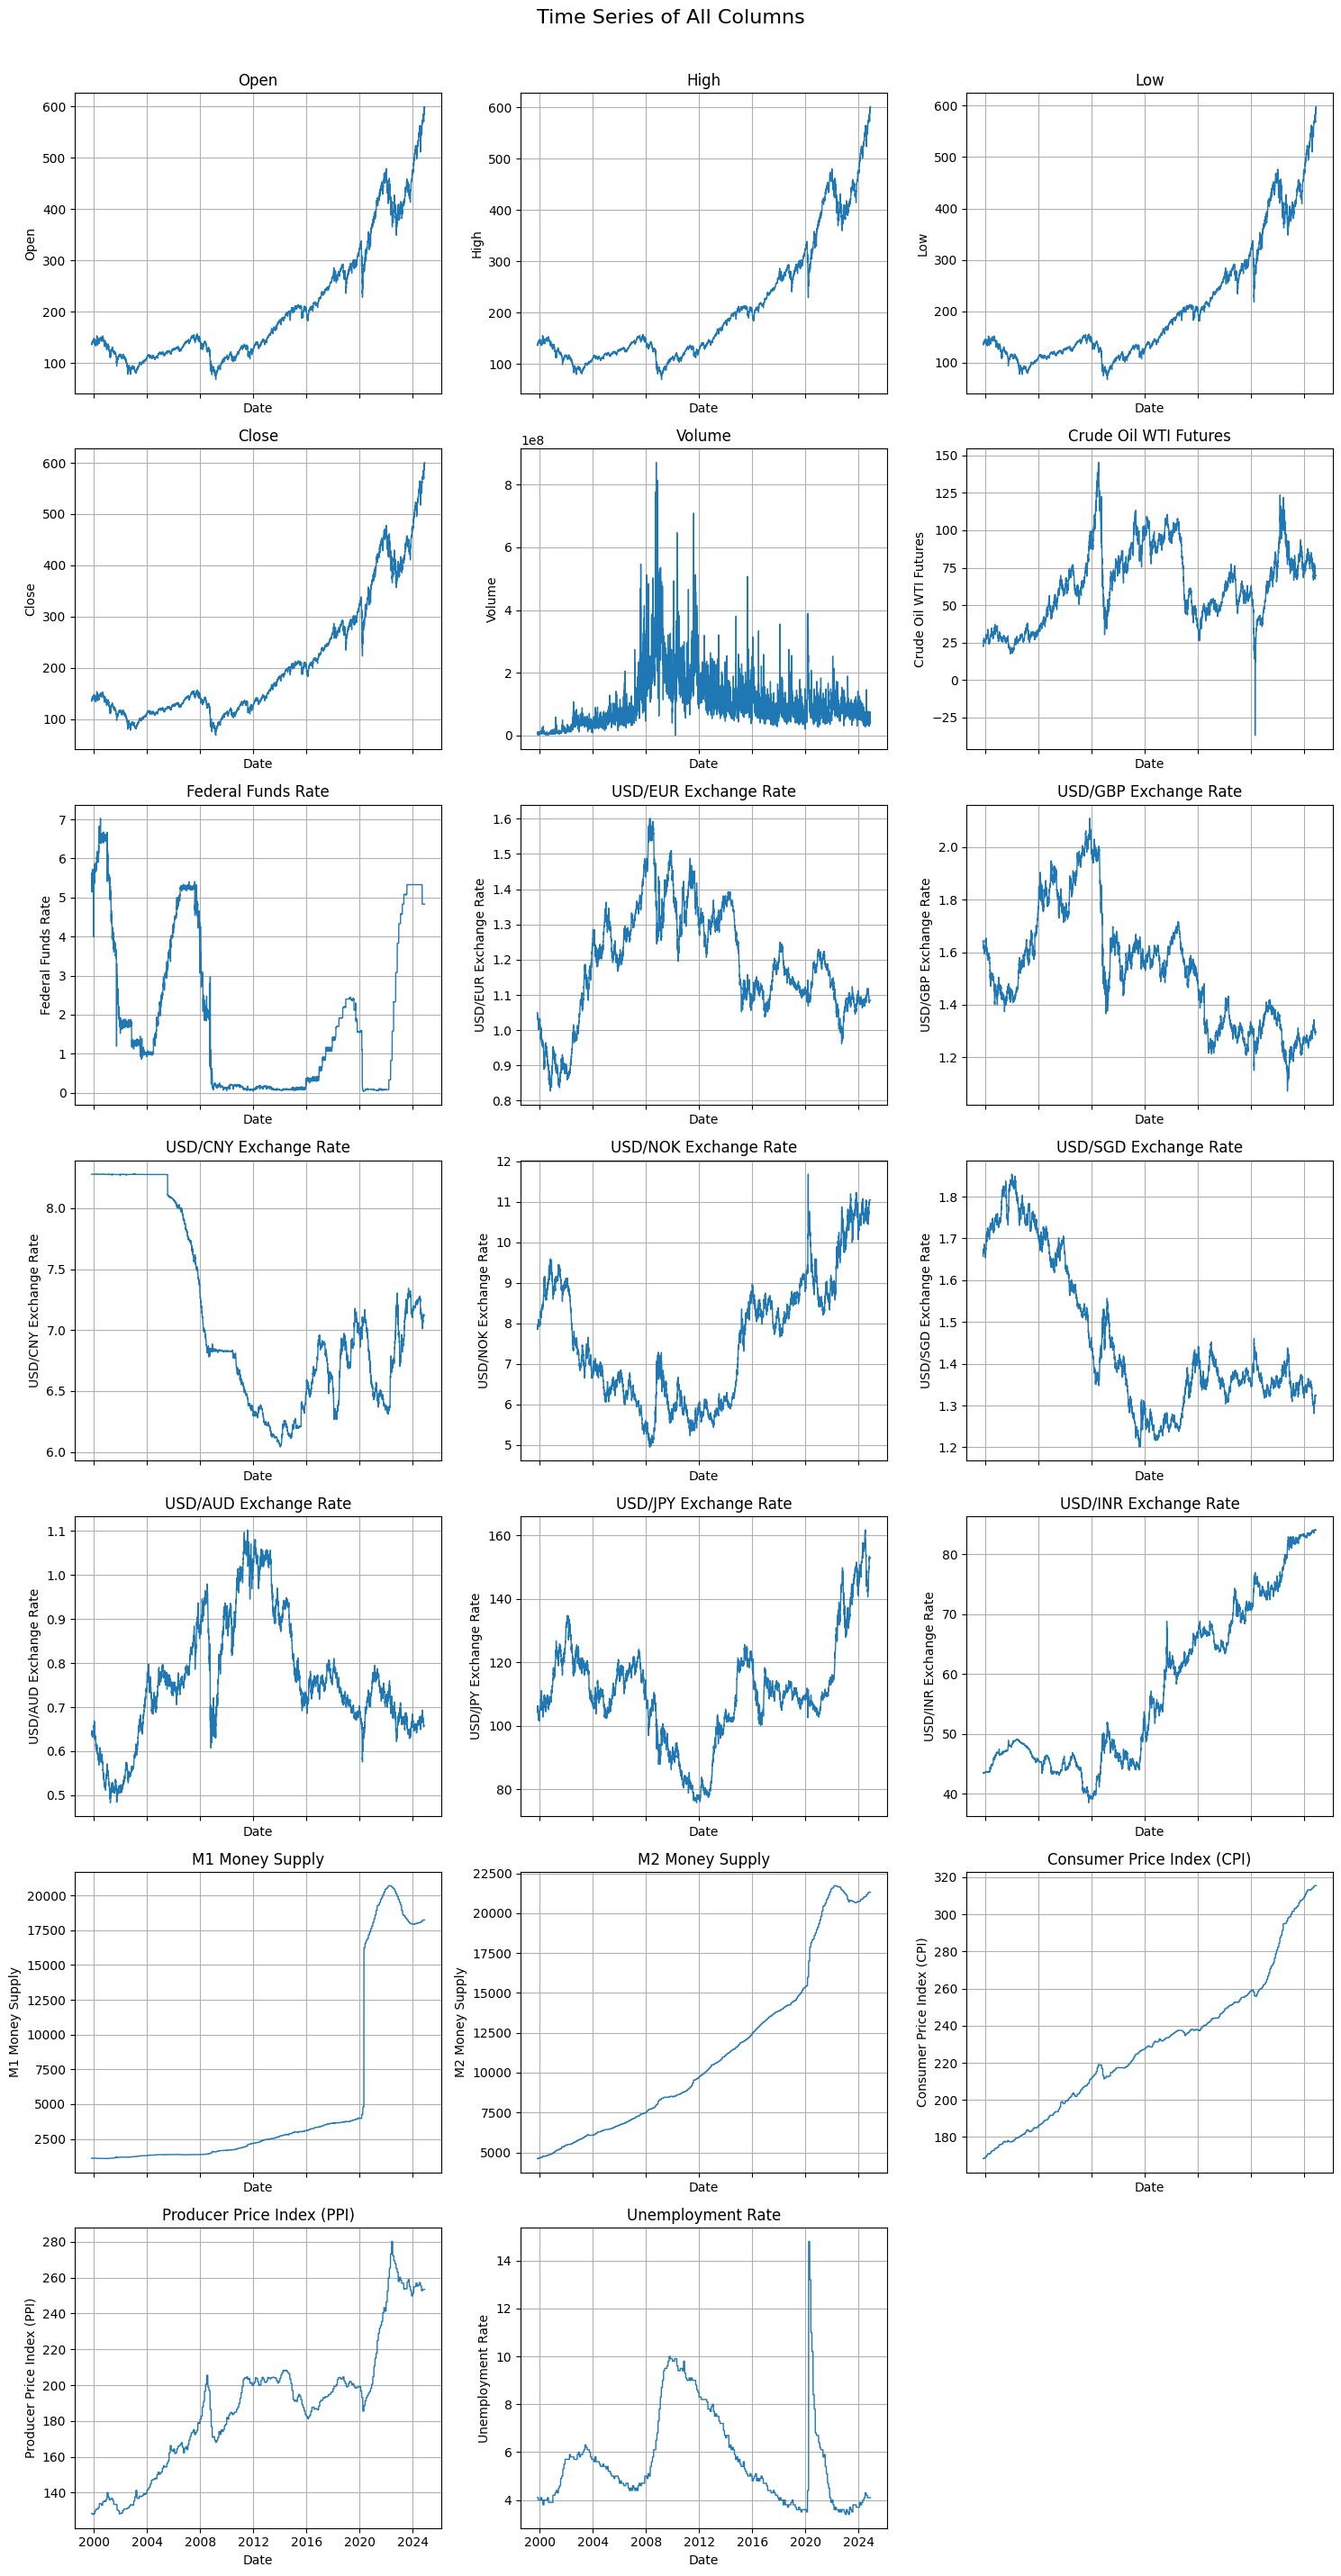

In [11]:
# Determine the number of columns and rows for the grid layout
columns_per_row = 3  # Number of subplots per row
total_columns = [col for col in combined_df.columns if col != 'Date']  # Exclude the 'Date' column
total_plots = len(total_columns)
rows = math.ceil(total_plots / columns_per_row)  # Calculate number of rows needed

# Create the grid layout for subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(15, rows * 4), sharex=True)
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each column in a separate subplot
for i, column in enumerate(total_columns):
    ax = axes[i]
    ax.plot(combined_df['Date'], combined_df[column], linewidth=1)
    ax.set_title(column, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.grid(True)

# Remove empty subplots if the number of plots is not a perfect multiple of columns_per_row
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Time Series of All Columns", fontsize=16, y=1.02)  # Add an overall title
plt.show()


In [12]:
# combined_df.to_csv('combined_df.csv', index=False)

In [13]:
df = combined_df.copy()

# Ensure the data is sorted by date
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

# 1. Candlestick Pattern Classification (13 classes)
eight_trigram_patterns = [
    'BullishHorn', 'BearHorn', 'BullishHigh', 'BearHigh',
    'BullishLow', 'BearLow', 'BullishHarami', 'BearHarami'
]

def classify_eight_trigram(row):
    # Skip the first row as there's no previous day to compare
    if row.name == 0:
        return 'Neutral'

    # Today's and yesterday's high, low, close prices
    ht = row['High']
    lt = row['Low']
    ct = row['Close']

    ht_prev = df.loc[row.name - 1, 'High']
    lt_prev = df.loc[row.name - 1, 'Low']
    ct_prev = df.loc[row.name - 1, 'Close']

    # Apply the eight-trigram conditions
    # 1. BullishHorn
    if (ht > ht_prev) and (lt < lt_prev) and (ct > ct_prev):
        return 'BullishHorn'

    # 2. BearHorn
    elif (ht > ht_prev) and (lt < lt_prev) and (ct < ct_prev):
        return 'BearHorn'

    # 3. BullishHigh
    elif (ht > ht_prev) and (lt > lt_prev) and (ct > ct_prev):
        return 'BullishHigh'

    # 4. BearHigh
    elif (ht > ht_prev) and (lt > lt_prev) and (ct < ct_prev):
        return 'BearHigh'

    # 5. BullishLow
    elif (ht < ht_prev) and (lt < lt_prev) and (ct > ct_prev):
        return 'BullishLow'

    # 6. BearLow
    elif (ht < ht_prev) and (lt < lt_prev) and (ct < ct_prev):
        return 'BearLow'

    # 7. BullishHarami
    elif (ht < ht_prev) and (lt > lt_prev) and (ct > ct_prev):
        return 'BullishHarami'

    # 8. BearHarami
    elif (ht < ht_prev) and (lt > lt_prev) and (ct < ct_prev):
        return 'BearHarami'

    else:
        return 'Neutral'

# Apply the function to classify each row
df['Eight_Trigram_Pattern'] = df.apply(classify_eight_trigram, axis=1)

# Map patterns to numerical codes
df['Eight_Trigram_Code'] = df['Eight_Trigram_Pattern'].map({
    'BullishHorn': 1,
    'BearHorn': 2,
    'BullishHigh': 3,
    'BearHigh': 4,
    'BullishLow': 5,
    'BearLow': 6,
    'BullishHarami': 7,
    'BearHarami': 8,
    'Neutral': 0
})

# 2. Inter-day Price Movement Patterns (Eight-Trigram Scheme)
# Again, we'll use standard definitions due to lack of specifics

def classify_inter_day(row):
    if row.name == 0:
        return 'Neutral'  # No previous day to compare with
    else:
        prev_close = df.loc[row.name - 1, 'Close']
        today_open = row['Open']

        if today_open > prev_close:
            movement = 'Gap Up'
        elif today_open < prev_close:
            movement = 'Gap Down'
        else:
            movement = 'No Gap'

        # Further classification can be added based on High and Low
        return movement



In [14]:
# 1. Custom Functions and Initial Features
df['Inter_Day_Movement'] = df.apply(classify_inter_day, axis=1)
df['Inter_Day_Movement_Code'] = pd.factorize(df['Inter_Day_Movement'])[0]

# 2. Volume Rate of Change
look_back_period = 5  # Adjust based on your analysis needs
n = look_back_period  # Define n based on look_back_period
df['Volume_ROC'] = df['Volume'].pct_change(periods=n) * 100

# 3. Overlap Indicators
## Simple Moving Averages
df['SMA_5'] = ta.trend.SMAIndicator(close=df['Close'], window=5).sma_indicator()
df['SMA_10'] = ta.trend.SMAIndicator(close=df['Close'], window=10).sma_indicator()
# df['SMA_20'] = ta.trend.SMAIndicator(close=df['Close'], window=20).sma_indicator()
df['SMA_30'] = ta.trend.SMAIndicator(close=df['Close'], window=30).sma_indicator()

## Exponential Moving Averages
df['EMA_10'] = ta.trend.EMAIndicator(close=df['Close'], window=10).ema_indicator()
# df['EMA_20'] = ta.trend.EMAIndicator(close=df['Close'], window=20).ema_indicator()
df['EMA_30'] = ta.trend.EMAIndicator(close=df['Close'], window=30).ema_indicator()

## Double Exponential Moving Average (DEMA)
def calculate_dema(series, window):
    ema = ta.trend.EMAIndicator(close=series, window=window).ema_indicator()
    ema_ema = ta.trend.EMAIndicator(close=ema, window=window).ema_indicator()
    dema = 2 * ema - ema_ema
    return dema

df['DEMA_5'] = calculate_dema(df['Close'], window=5)
df['DEMA_30'] = calculate_dema(df['Close'], window=30)

## Triple Exponential Moving Average (TEMA)
def calculate_tema(series, window):
    ema1 = ta.trend.EMAIndicator(close=series, window=window).ema_indicator()
    ema2 = ta.trend.EMAIndicator(close=ema1, window=window).ema_indicator()
    ema3 = ta.trend.EMAIndicator(close=ema2, window=window).ema_indicator()
    tema = 3 * (ema1 - ema2) + ema3
    return tema

df['TEMA_30'] = calculate_tema(df['Close'], window=30)

## Weighted Moving Average (WMA)
df['WMA_30'] = ta.trend.WMAIndicator(close=df['Close'], window=30).wma()

## Kaufman's Adaptive Moving Average (KAMA)
df['KAMA_5'] = ta.momentum.KAMAIndicator(close=df['Close'], window=5).kama()

## Parabolic SAR
psar = ta.trend.PSARIndicator(high=df['High'], low=df['Low'], close=df['Close'])
df['PSAR'] = psar.psar()

## Bollinger Bands
bb = ta.volatility.BollingerBands(close=df['Close'], window=5, window_dev=2)
df['BB_UPPER'] = bb.bollinger_hband()
df['BB_MIDDLE'] = bb.bollinger_mavg()
df['BB_LOWER'] = bb.bollinger_lband()

# 4. Momentum Indicators
## Average Directional Movement Index (ADX)
df['ADX_10'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=10).adx()
# df['ADX_14'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=14).adx()

## Commodity Channel Index (CCI)
df['CCI_10'] = ta.trend.CCIIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=10).cci()

## Moving Average Convergence Divergence (MACD)
macd = ta.trend.MACD(close=df['Close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD'] = macd.macd()
df['MACD_SIGNAL'] = macd.macd_signal()
df['MACD_HIST'] = macd.macd_diff()

## Relative Strength Index (RSI)
df['RSI_10'] = ta.momentum.RSIIndicator(close=df['Close'], window=10).rsi()
# df['RSI_14'] = ta.momentum.RSIIndicator(close=df['Close'], window=14).rsi()

## Money Flow Index (MFI)
df['MFI_10'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=10).money_flow_index()
# df['MFI_14'] = ta.volume.MFIIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume'], window=14).money_flow_index()

## Rate of Change (ROC)
df['ROC_10'] = ta.momentum.ROCIndicator(close=df['Close'], window=10).roc()

## Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])
df['STOCH_%K'] = stoch.stoch()
df['STOCH_%D'] = stoch.stoch_signal()

## Williams %R
df['WILLR_10'] = ta.momentum.WilliamsRIndicator(high=df['High'], low=df['Low'], close=df['Close'], lbp=10).williams_r()

## Ultimate Oscillator (ULTOSC)
df['ULTOSC'] = ta.momentum.UltimateOscillator(high=df['High'], low=df['Low'], close=df['Close']).ultimate_oscillator()

# Balance of Power (BOP)
df['BOP'] = (df['Close'] - df['Open']) / (df['High'] - df['Low'])
df['BOP'] = df['BOP'].replace([np.inf, -np.inf], np.nan).fillna(0)

## Chande Momentum Oscillator (CMO)
def calculate_cmo(series, window):
    delta = series.diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)
    sum_gain = gain.rolling(window=window).sum()
    sum_loss = loss.rolling(window=window).sum()
    cmo = 100 * (sum_gain - sum_loss) / (sum_gain + sum_loss)
    return cmo
df['CMO_10'] = calculate_cmo(df['Close'], window=10)

# 5. Volume Indicators
## Accumulation/Distribution Index (ADI
df['ADI'] = ta.volume.AccDistIndexIndicator(high=df['High'], low=df['Low'], close=df['Close'], volume=df['Volume']).acc_dist_index()

## On-Balance Volume (OBV)
df['OBV'] = ta.volume.OnBalanceVolumeIndicator(close=df['Close'], volume=df['Volume']).on_balance_volume()

## Chaikin Money Flow (CMF)
def calculate_chaikin_oscillator(high, low, close, volume, fast_period=3, slow_period=10):
    ad = ta.volume.AccDistIndexIndicator(high=high, low=low, close=close, volume=volume).acc_dist_index()
    ema_fast = ta.trend.EMAIndicator(close=ad, window=fast_period).ema_indicator()
    ema_slow = ta.trend.EMAIndicator(close=ad, window=slow_period).ema_indicator()
    adosc = ema_fast - ema_slow
    return adosc
df['ADOSC'] = calculate_chaikin_oscillator(df['High'], df['Low'], df['Close'], df['Volume'])

# 6. Volatility Indicators
## Average True Range (ATR)
df['ATR_10'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=10).average_true_range()
# df['ATR_14'] = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close'], window=14).average_true_range()

## Normalized Average True Range (NATR)
df['NATR_10'] = (df['ATR_10'] / df['Close']) * 100
# df['NATR_14'] = (df['ATR_14'] / df['Close']) * 100

## True Range (TRANGE)
def calculate_true_range(high, low, close):
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    return tr
df['TRANGE'] = calculate_true_range(df['High'], df['Low'], df['Close'])

# 7. Other Indicators
## Average Price
df['AVGPRICE'] = (df['Open'] + df['High'] + df['Low'] + df['Close']) / 4

## Median Price
df['MEDPRICE'] = (df['High'] + df['Low']) / 2

## Typical Price
df['TYPPRICE'] = (df['High'] + df['Low'] + df['Close']) / 3

## Weighted Close Price
df['WCLPRICE'] = (df['High'] + df['Low'] + 2 * df['Close']) / 4

# 8. Lagged Features
# df['Lag_1'] = df['Close'].shift(1)
# df['Lag_2'] = df['Close'].shift(2)

# 9. Returns
df['Return'] = df['Close'].pct_change()

# 10. Rolling Statistics
df['Rolling_Median_10'] = df['Close'].rolling(window=10).median()
df['Rolling_Std_10'] = df['Close'].rolling(window=10).std()
df['Rolling_Median_5'] = df['Close'].rolling(window=5).median()
df['Rolling_Std_5'] = df['Close'].rolling(window=5).std()

# 11. Time-Based Features
df['Day_of_Week'] = df['Date'].dt.dayofweek
df['Month'] = df['Date'].dt.month

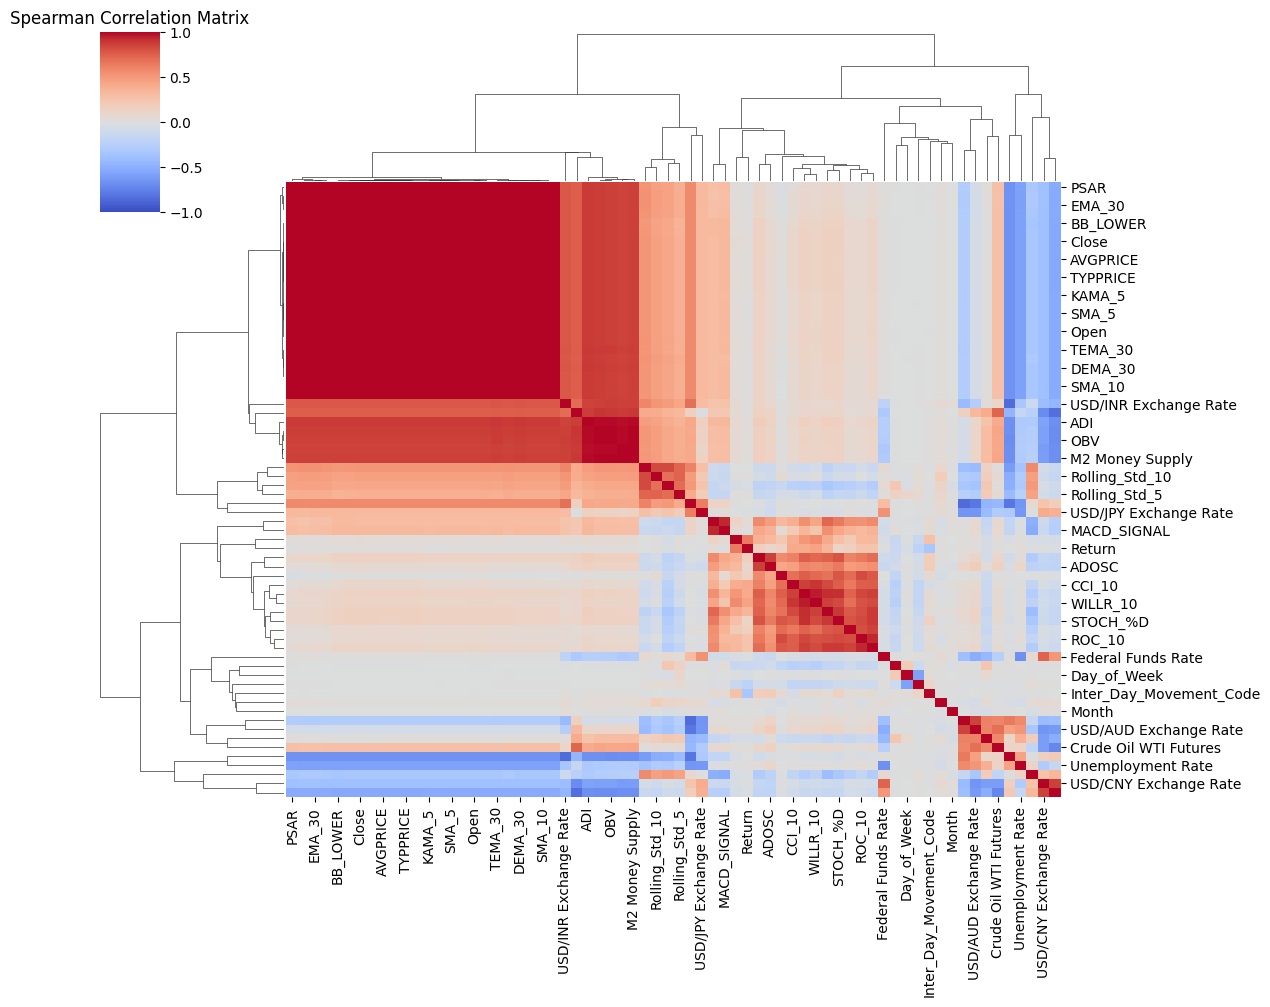

Groups of highly correlated features:
{'EMA_10', 'Open', 'DEMA_30', 'AVGPRICE', 'PSAR', 'WCLPRICE', 'SMA_30', 'WMA_30', 'High', 'EMA_30', 'KAMA_5', 'SMA_5', 'Rolling_Median_10', 'Low', 'Close', 'TYPPRICE', 'BB_MIDDLE', 'Rolling_Median_5', 'DEMA_5', 'TEMA_30', 'SMA_10', 'BB_UPPER', 'MEDPRICE', 'BB_LOWER'}
{'M1 Money Supply', 'OBV', 'Consumer Price Index (CPI)', 'M2 Money Supply', 'ADI'}
{'WILLR_10', 'STOCH_%K'}


In [15]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = numeric_df.corr(method='spearman')

# Set a threshold for high correlation
threshold = 0.95

# Create a mask to identify highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Create a graph to group highly correlated features
G = nx.Graph()
G.add_edges_from(high_corr_var)

# Find connected components (groups of highly correlated features)
groups = list(nx.connected_components(G))

# Remove one feature from each highly correlated group
features_to_remove = set()
for group in groups:
    features_to_remove.update(list(group)[1:])  # Keep one feature from each group

numeric_df.drop(columns=features_to_remove, inplace=True)

# Visualize the correlation matrix using a clustermap without annotations
sns.clustermap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 10))
plt.title('Spearman Correlation Matrix')
plt.show()

# Print the groups of highly correlated features
print("Groups of highly correlated features:")
for group in groups:
    print(group)

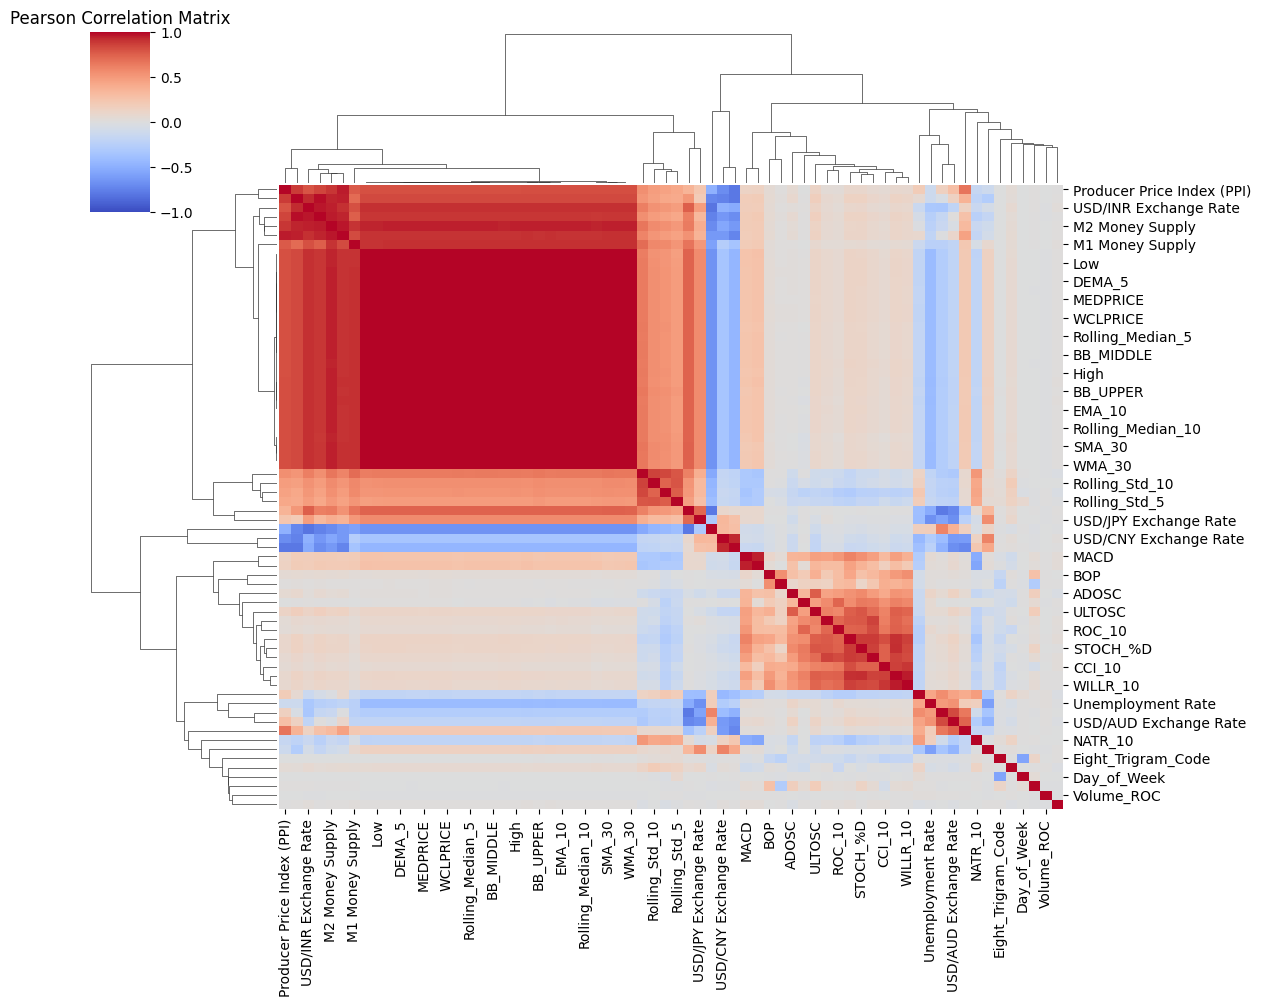

Groups of highly correlated features:
{'EMA_10', 'Open', 'DEMA_30', 'AVGPRICE', 'PSAR', 'WCLPRICE', 'SMA_30', 'WMA_30', 'High', 'EMA_30', 'KAMA_5', 'SMA_5', 'Rolling_Median_10', 'Low', 'Close', 'TYPPRICE', 'BB_MIDDLE', 'Rolling_Median_5', 'DEMA_5', 'TEMA_30', 'SMA_10', 'BB_UPPER', 'MEDPRICE', 'BB_LOWER'}
{'OBV', 'USD/INR Exchange Rate', 'Producer Price Index (PPI)', 'Consumer Price Index (CPI)', 'M2 Money Supply', 'ADI'}
{'MACD', 'MACD_SIGNAL'}
{'WILLR_10', 'STOCH_%K'}


In [16]:
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])

# Calculate the Spearman correlation matrix
corr_matrix = numeric_df.corr(method='pearson')

# Set a threshold for high correlation
threshold = 0.95

# Create a mask to identify highly correlated features
high_corr_var = np.where(np.abs(corr_matrix) > threshold)
high_corr_var = [(corr_matrix.index[x], corr_matrix.columns[y]) for x, y in zip(*high_corr_var) if x != y and x < y]

# Create a graph to group highly correlated features
G = nx.Graph()
G.add_edges_from(high_corr_var)

# Find connected components (groups of highly correlated features)
groups = list(nx.connected_components(G))

# Remove one feature from each highly correlated group
features_to_remove = set()
for group in groups:
    features_to_remove.update(list(group)[1:])  # Keep one feature from each group

numeric_df.drop(columns=features_to_remove, inplace=True)

# Visualize the correlation matrix using a clustermap without annotations
sns.clustermap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1, figsize=(12, 10))
plt.title('Pearson Correlation Matrix')
plt.show()

# Print the groups of highly correlated features
print("Groups of highly correlated features:")
for group in groups:
    print(group)

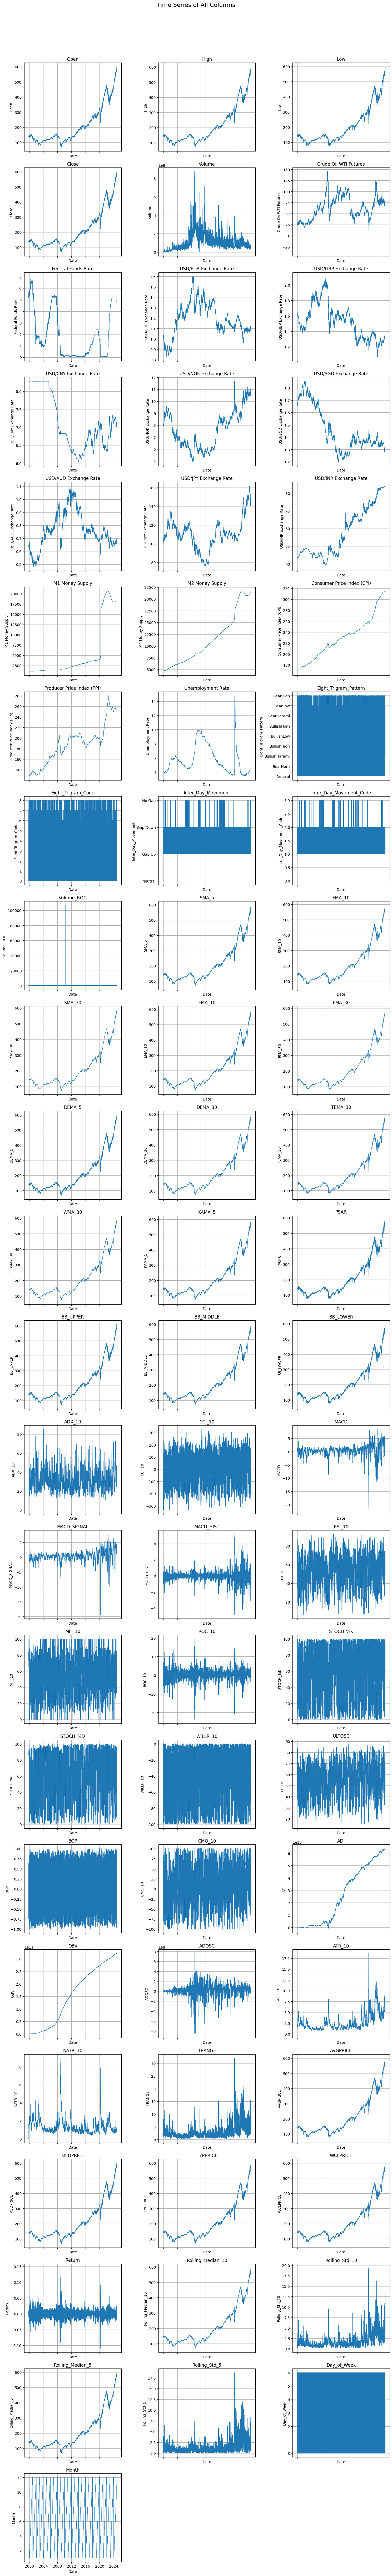

In [17]:
# Determine the number of columns and rows for the grid layout
columns_per_row = 3  # Number of subplots per row
total_columns = [col for col in df.columns if col != 'Date']  # Exclude the 'Date' column
total_plots = len(total_columns)
rows = math.ceil(total_plots / columns_per_row)  # Calculate number of rows needed

# Create the grid layout for subplots
fig, axes = plt.subplots(rows, columns_per_row, figsize=(15, rows * 4), sharex=True)
axes = axes.flatten()  # Flatten axes array for easy indexing

# Plot each column in a separate subplot
for i, column in enumerate(total_columns):
    ax = axes[i]
    ax.plot(df['Date'], df[column], linewidth=1)
    ax.set_title(column, fontsize=12)
    ax.set_xlabel("Date", fontsize=10)
    ax.set_ylabel(column, fontsize=10)
    ax.grid(True)

# Remove empty subplots if the number of plots is not a perfect multiple of columns_per_row
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Time Series of All Columns", fontsize=16, y=1.02)  # Add an overall title
plt.show()


In [18]:
# # First, let me see your current DataFrame before applying the function
# print("Original DataFrame shape:", df1.shape)
# print("Original columns:", df1.columns.tolist())

# # Apply the create_features function
# df_processed = reduce_and_create_features(df1)

# print("\nProcessed DataFrame shape:", df_processed.shape)
# print("Processed columns:", df_processed.columns.tolist())


In [19]:
# def transform_features(df_processed):
#     epsilon = 1e-10
    
#     # Features that need log transformation (absolute values, typically right-skewed)
#     log_features = [
#         'Close', 
#         'Volume', 
#         'Volume_MA',
#         'Crude Oil WTI Futures', 
#         'M1 Money Supply'
#     ]
#     # Exchange rate features (use natural log)
#     exchange_features = [
#         'USD/EUR Exchange Rate', 'USD/GBP Exchange Rate', 
#         'USD/CNY Exchange Rate', 'USD/JPY Exchange Rate'
#     ]
    
#     # Apply log1p transformation
#     df_processed[log_features] = df_processed[log_features].apply(lambda x: np.log1p(x + epsilon))
    
#     # Apply natural log to exchange rates
#     df_processed[exchange_features] = df_processed[exchange_features].apply(lambda x: np.log(x + epsilon))
    
#     return df_processed

# # Apply the transformations
# df_transformed = transform_features(df_processed.copy())

# # Quick verification
# print("\nVerifying transformations - checking for any infinite values:")
# print(np.isinf(df_transformed).sum())
# print("\nChecking for any NaN values:")
# print(df_transformed.isna().sum())

In [20]:
# Add a small constant to avoid log(0) or log of negative values
epsilon = 1e-10

# Log transformation for numerical columns except 'Close', 'Date', 'Day_of_Week', and 'Month'
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numerical_cols.remove('Close')
if 'Day_of_Week' in numerical_cols:
	numerical_cols.remove('Day_of_Week')
if 'Month' in numerical_cols:
	numerical_cols.remove('Month')

# Check for negative or zero values and shift if necessary
negative_cols = [col for col in numerical_cols if (df[col] + epsilon <= 0).any()]
for col in negative_cols:
    min_val = df[col].min()
    df[col] = df[col] - min_val + 1  # Shift to make all values positive

# Apply log transformation
df[numerical_cols] = df[numerical_cols].apply(lambda x: np.log1p(x + epsilon))

# Sine and cosine transformation for 'Day_of_Week' and 'Month'
df['Day_of_Week_sin'] = np.sin(2 * np.pi * df['Day_of_Week'] / 7)
df['Day_of_Week_cos'] = np.cos(2 * np.pi * df['Day_of_Week'] / 7)
df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
df.drop(['Day_of_Week', 'Month'], axis=1, inplace=True)

# One-hot encoding for categorical columns
categorical_cols = ['Eight_Trigram_Pattern', 'Inter_Day_Movement']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # drop_first=True to avoid dummy variable trap

In [21]:
# Check for negative values after log transformation
for col in numerical_cols:
    if (df[col] <= 0).any():
        print(f'Non-positive values found in {col} after log transformation.')

In [22]:
# Handle missing values if any
if df.isnull().values.any():
    df = df.dropna().reset_index(drop=True)

In [23]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate',
       'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate',
       'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate',
       'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate',
       'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply',
       'Consumer Price Index (CPI)', 'Producer Price Index (PPI)',
       'Unemployment Rate', 'Eight_Trigram_Code', 'Inter_Day_Movement_Code',
       'Volume_ROC', 'SMA_5', 'SMA_10', 'SMA_30', 'EMA_10', 'EMA_30', 'DEMA_5',
       'DEMA_30', 'TEMA_30', 'WMA_30', 'KAMA_5', 'PSAR', 'BB_UPPER',
       'BB_MIDDLE', 'BB_LOWER', 'ADX_10', 'CCI_10', 'MACD', 'MACD_SIGNAL',
       'MACD_HIST', 'RSI_10', 'MFI_10', 'ROC_10', 'STOCH_%K', 'STOCH_%D',
       'WILLR_10', 'ULTOSC', 'BOP', 'CMO_10', 'ADI', 'OBV', 'ADOSC', 'ATR_10',
       'NATR_10', 'TRANGE', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE',
       'Return', 'Rolling_

In [24]:
# Step 1: Filter the DataFrame with selected features
features_set1 = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']
df_set1 = df[features_set1].copy()

# Step 2: Save the filtered DataFrame to a CSV file
df_set1.to_csv('data_set1.csv', index=False)

In [25]:
# Step 1: Filter the DataFrame with selected features
features_set2 = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate',
       'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate',
       'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate',
       'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate',
       'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply',
       'Consumer Price Index (CPI)', 'Producer Price Index (PPI)',
       'Unemployment Rate']
df_set2 = df[features_set2].copy()

# Step 2: Save the filtered DataFrame to a CSV file
df_set2.to_csv('data_set2.csv', index=False)

In [26]:
# Step 1: Filter the DataFrame with selected features
df_set3 = df.copy()

# Step 2: Save the filtered DataFrame to a CSV file
df_set3.to_csv('data_set3.csv', index=False)

In [70]:
df_set2.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume',
       'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate',
       'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate',
       'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate',
       'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate',
       'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply',
       'Consumer Price Index (CPI)', 'Producer Price Index (PPI)',
       'Unemployment Rate'],
      dtype='object')

In [71]:
df_set1.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [47]:
df_closing = df_set2['Close']
df_closing.head()


0    140.2500
1    135.8750
2    135.8750
3    135.8750
4    139.5625
Name: Close, dtype: float64

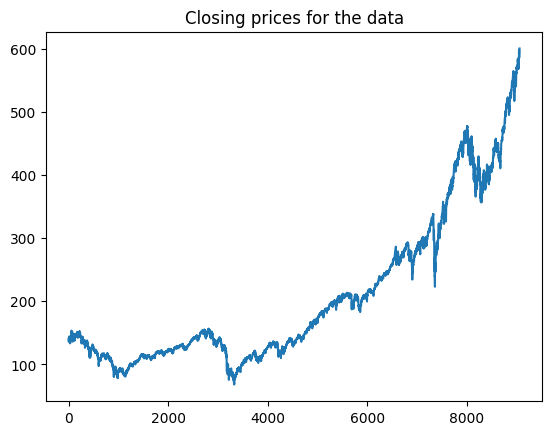

In [48]:
plt.plot(df_closing.values);
plt.title("Closing prices for the data");

In [49]:
scaler=MinMaxScaler(feature_range=(0,1))
df_closing=scaler.fit_transform(np.array(df_closing).reshape(-1,1))

In [50]:
def create_dataset(dataset, time_step=1):
    x_data, y_data = [], []
    
    for i in range(len(dataset)-time_step-1):
        x_data.append(dataset[i:(i+time_step), 0])
        y_data.append(dataset[i + time_step, 0])
    return np.array(x_data), np.array(y_data)

In [51]:
training_size=int(len(df_closing)*0.65)
test_size=len(df_closing)-training_size
train_data,test_data=df_closing[0:training_size,:],df_closing[training_size:len(df_closing),:1]

In [52]:
#Taking data for past 14 days for next prediction
time_step = 100

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

In [53]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM

In [55]:
from kerastuner import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Choice('layer1_units', [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]), return_sequences=True, input_shape=(100, 1)))
    
    for i in range(hp.Int('num_layers', 2, 15)):
        model.add(LSTM(units=hp.Int('units' + str(i), min_value=10, max_value=150, step=10), return_sequences=True))
    
    model.add(LSTM(units=hp.Choice('last_lstm_units', [50, 100, 150])))
    model.add(Dropout(rate=hp.Choice('rate', [0.3, 0.4, 0.5, 0.6, 0.7])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,
    executions_per_trial=3,
    directory='project', project_name='Stacked_LSTM_Stock_Prediction')

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=5,
             validation_data=(X_test, y_test))

Reloading Tuner from project\Stacked_LSTM_Stock_Prediction\tuner0.json
Search space summary
Default search space size: 18
layer1_units (Choice)
{'default': 10, 'conditions': [], 'values': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'ordered': True}
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 15, 'step': 1, 'sampling': 'linear'}
units0 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units1 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
last_lstm_units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 150], 'ordered': True}
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5, 0.6, 0.7], 'ordered': True}
units2 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_value': 150, 'step': 10, 'sampling': 'linear'}
units3 (Int)
{'default': None, 'conditions': [], 'min_value': 10, 'max_val

In [56]:
tuner.results_summary()

Results summary
Results in project\Stacked_LSTM_Stock_Prediction
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 3 summary
Hyperparameters:
layer1_units: 40
num_layers: 2
units0: 140
units1: 90
last_lstm_units: 100
rate: 0.6
units2: 120
units3: 50
units4: 80
units5: 50
units6: 120
units7: 100
units8: 40
units9: 130
units10: 30
units11: 90
units12: 140
units13: 120
Score: 0.0005166833191954842

Trial 4 summary
Hyperparameters:
layer1_units: 40
num_layers: 8
units0: 110
units1: 130
last_lstm_units: 100
rate: 0.3
units2: 60
units3: 100
units4: 50
units5: 60
units6: 110
units7: 150
units8: 120
units9: 150
units10: 140
units11: 110
units12: 140
units13: 50
Score: 0.02940172329545021

Trial 1 summary
Hyperparameters:
layer1_units: 60
num_layers: 8
units0: 130
units1: 60
last_lstm_units: 150
rate: 0.4
units2: 80
units3: 30
units4: 10
units5: 130
units6: 100
units7: 30
units8: 60
units9: 80
units10: 20
units11: 120
Score: 0.03617062295476595

Trial 2 summary
Hyperpara

In [57]:
stackedLSTM_model = tuner.get_best_models(num_models=1)[0]
stackedLSTM_model.summary()

C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 30 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 40)        │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 140)       │       101,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 90)        │        83,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 100)            │        76,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 267,741 (1.02 MB)

 Trainable params: 267,741 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
stackedLSTM_history = stackedLSTM_model.fit(X_train,y_train, epochs=100, validation_data=(X_test,y_test))


Epoch 1/100


181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - loss: 1.6759e-04 - val_loss: 6.8101e-04
Epoch 2/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 1.2502e-04 - val_loss: 0.0012
Epoch 3/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 94ms/step - loss: 1.1582e-04 - val_loss: 4.3684e-04
Epoch 4/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 17s 93ms/step - loss: 1.2444e-04 - val_loss: 0.0030
Epoch 5/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 19s 104ms/step - loss: 1.1170e-04 - val_loss: 6.4526e-04
Epoch 6/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 151ms/step - loss: 1.0751e-04 - val_loss: 0.0033
Epoch 7/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 150ms/step - loss: 9.2604e-05 - val_loss: 0.0015
Epoch 8/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 27s 149ms/step - loss: 1.0166e-04 - val_loss: 5.3337e-04
Epoch 9/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 143ms/step - loss: 9.7120e-05 - val_loss: 0.0022
Epoch 10/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 26s 145ms/step - loss: 9.6794e-05 - val_loss: 0.0026
Epoch 11/100
181/181 ━━━━━━━━━━━━━━━━━━━━ 25s 138ms/step - 

KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss : Training Vs Validation ')

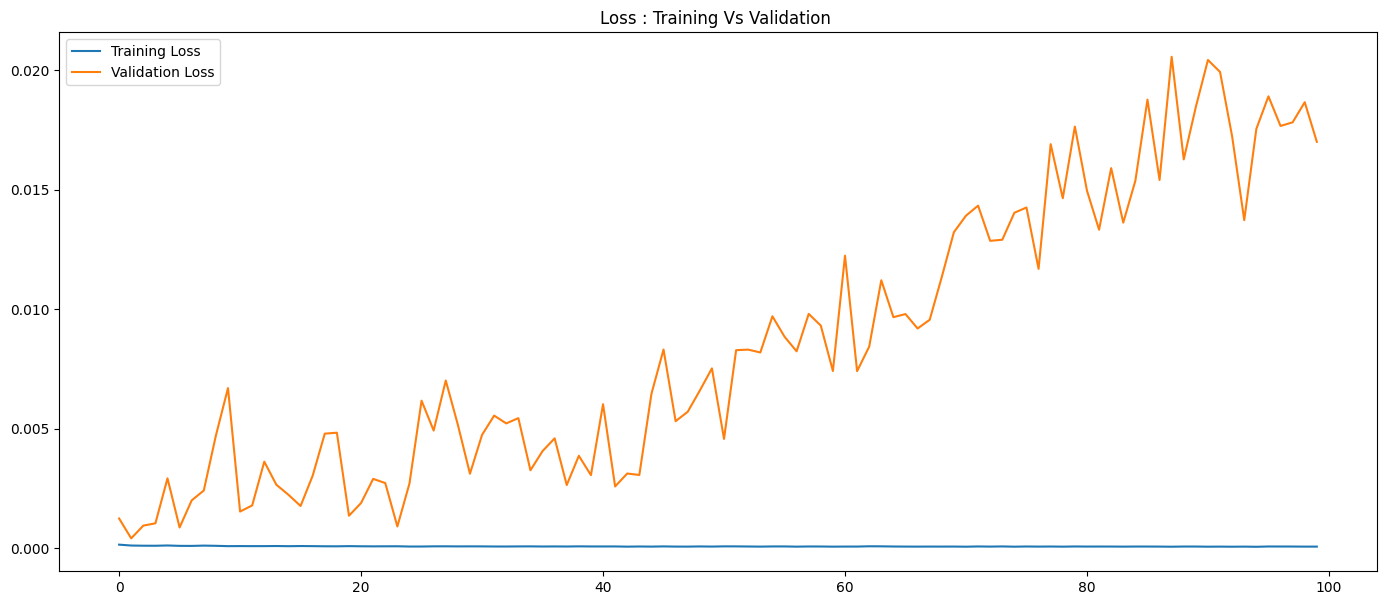

In [ ]:
loss = stackedLSTM_history.history['loss']
validation_loss = stackedLSTM_history.history['val_loss']



plt.figure(figsize=(17, 7))
plt.plot(range(100), loss, label='Training Loss')
plt.plot(range(100), validation_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Loss : Training Vs Validation ')

In [41]:
train_predict=stackedLSTM_model.predict(X_train)
test_predict=stackedLSTM_model.predict(X_test)

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [42]:
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [46]:
print("Train RMSE: ", math.sqrt(mean_squared_error(y_train,train_predict)))
print("Test RMSE: ", math.sqrt(mean_squared_error(y_test,test_predict)))

Train RMSE:  138.61958714609813
Test RMSE:  306.95373725888123


In [75]:
def prepare_time_series_data(df, target_col='Close', train_split=0.8):
    """
    Prepare time series data for modeling
    """
    # Create a copy to avoid modifying original data
    df = df.copy()
    
    # Convert index to datetime if not already
    if not isinstance(df.index, pd.DatetimeIndex):
        if 'Date' in df.columns:
            df.set_index('Date', inplace=True)
        df.index = pd.to_datetime(df.index)
    
    # Time series train-test split
    train_size = int(len(df) * train_split)
    train_df = df[:train_size]
    test_df = df[train_size:]
    
    print("Training data from:", train_df.index[0], "to:", train_df.index[-1])
    print("Testing data from:", test_df.index[0], "to:", test_df.index[-1])
    
    # Separate features and target, excluding datetime columns
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    feature_cols = [col for col in numeric_cols if col != target_col]
    
    X_train_features = train_df[feature_cols]
    X_test_features = test_df[feature_cols]
    y_train = train_df[target_col]
    y_test = test_df[target_col]
    
    # Handle missing values if any
    X_train_features = X_train_features.fillna(method='ffill').fillna(method='bfill')
    X_test_features = X_test_features.fillna(method='ffill').fillna(method='bfill')
    
    # Standardization
    scaler = StandardScaler()
    scaled_X_train = scaler.fit_transform(X_train_features)
    scaled_X_test = scaler.transform(X_test_features)
    
    # Scale y-features
    target_scaler = StandardScaler()
    scaled_y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
    scaled_y_test = target_scaler.transform(y_test.values.reshape(-1, 1))
    
    # Convert scaled features back to DataFrame
    scaled_train_df = pd.DataFrame(
        scaled_X_train, 
        columns=feature_cols, 
        index=X_train_features.index
    )
    scaled_test_df = pd.DataFrame(
        scaled_X_test, 
        columns=feature_cols, 
        index=X_test_features.index
    )
    
    prepared_data = {
        'X_train': scaled_train_df,
        'X_test': scaled_test_df,
        'y_train': scaled_y_train,
        'y_test': scaled_y_test,
        'feature_scaler': scaler,
        'target_scaler': target_scaler,
        'feature_columns': feature_cols,
        'train_indices': train_df.index,
        'test_indices': test_df.index
    }
    return prepared_data

# Usage:
prepared_data1 = prepare_time_series_data(df_set1)
prepared_data2 = prepare_time_series_data(df_set2)
prepared_data3 = prepare_time_series_data(df_set3)

Training data from: 2000-01-27 00:00:00 to: 2019-12-02 00:00:00
Testing data from: 2019-12-03 00:00:00 to: 2024-11-26 00:00:00
Training data from: 2000-01-27 00:00:00 to: 2019-12-02 00:00:00
Testing data from: 2019-12-03 00:00:00 to: 2024-11-26 00:00:00
Training data from: 2000-01-27 00:00:00 to: 2019-12-02 00:00:00
Testing data from: 2019-12-03 00:00:00 to: 2024-11-26 00:00:00


C:\Users\karee\AppData\Local\Temp\ipykernel_26424\170235647.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train_features = X_train_features.fillna(method='ffill').fillna(method='bfill')
C:\Users\karee\AppData\Local\Temp\ipykernel_26424\170235647.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_test_features = X_test_features.fillna(method='ffill').fillna(method='bfill')
C:\Users\karee\AppData\Local\Temp\ipykernel_26424\170235647.py:32: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X_train_features = X_train_features.fillna(method='ffill').fillna(method='bfill')
C:\Users\karee\AppData\Local\Temp\ipykernel_26424\170235647.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise

In [242]:
# Impute monthly data using forward fill
for column in scaled_test_df.columns:
    scaled_test_df[column] = scaled_test_df[column].ffill()

# Impute monthly data using forward fill
for column in scaled_train_df.columns:
    scaled_train_df[column] = scaled_train_df[column].ffill()

In [243]:
# Function to create sequences with date mapping
def create_sequences_with_dates(feature_data, target_data,time_steps=10, horizon=1):
    X, y, dates = [], [], []
    dates_series = feature_data.index
    for i in range(len(feature_data) - time_steps - horizon + 1):
        X.append(feature_data.iloc[i:i + time_steps].values)
        y.append(target_data[i + time_steps + horizon - 1])
        dates.append([dates_series[i + time_steps + horizon - 1]])
    return np.array(X), np.array(y), np.array(dates)

time_steps = 14  # Number of past days to use for prediction
horizon = 1      # Predict T+1

X_train, y_train, dates_train = create_sequences_with_dates(scaled_train_df, scaled_y_train.reshape(-1), time_steps, horizon)
X_test, y_test, dates_test = create_sequences_with_dates(scaled_test_df, scaled_y_test.reshape(-1), time_steps, horizon)

model_params.update({
    'sequence_dates_train': dates_train,
    'sequence_dates_test': dates_test,
    'time_steps': time_steps,          
    'horizon': horizon,  
})

In [ ]:
# def create_sequences_transform(feature_data, time_steps=14, horizon=1):
    
#     # 1. Split into train/test
#     train_size = int(len(feature_data) * 0.8)
#     train_df = feature_data[:train_size]
#     test_df = feature_data[train_size:]
    
#     # 2. Separate features and target
#     feature_cols = feature_data.columns.drop(['Close'])
#     X_train_features = train_df[feature_cols]
#     X_test_features = test_df[feature_cols]
#     y_train = train_df['Close']
#     y_test = test_df['Close']
    
#     def transform_features(df):
#         epsilon = 1e-10
#         df_transformed = df.copy()
        
#         # Features that need log transformation
#         log_features = [col for col in df.columns if col in [
#             'Volume', 'Volume_MA', 'Crude Oil WTI Futures', 'M1 Money Supply'
#         ]]
        
#         # Exchange rate features
#         exchange_features = [col for col in df.columns if 'Exchange Rate' in col]
        
#         # Apply log1p transformation
#         if log_features:
#             df_transformed[log_features] = df_transformed[log_features].apply(
#                 lambda x: np.log1p(x + epsilon))
        
#         # Apply natural log to exchange rates
#         if exchange_features:
#             df_transformed[exchange_features] = df_transformed[exchange_features].apply(
#                 lambda x: np.log(x + epsilon))
            
#         return df_transformed
    
#     # Apply log transformations
#     X_train_log = transform_features(X_train_features)
#     X_test_log = transform_features(X_test_features)
    
#     # 4. Scale the features
#     feature_scaler = StandardScaler()
#     scaled_X_train = feature_scaler.fit_transform(X_train_log)
#     scaled_X_test = feature_scaler.transform(X_test_log)
    
#     # 5. Scale the target (Close price)
#     target_scaler = StandardScaler()
#     scaled_y_train = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
#     scaled_y_test = target_scaler.transform(y_test.values.reshape(-1, 1))
    
#     # Convert scaled features back to DataFrame
#     scaled_train_df = pd.DataFrame(scaled_X_train, 
#                                  columns=feature_cols, 
#                                  index=X_train_features.index)
#     scaled_test_df = pd.DataFrame(scaled_X_test, 
#                                 columns=feature_cols, 
#                                 index=X_test_features.index)
    
#     # 6. Create sequences
#     def create_sequences_from_data(feature_data, target_data, dates_index):
#         X, y, dates = [], [], []
#         for i in range(len(feature_data) - time_steps - horizon + 1):
#             X.append(feature_data[i:(i + time_steps)])
#             y.append(target_data[i + time_steps + horizon - 1])
#             dates.append([dates_index[i + time_steps + horizon - 1]])
#         return np.array(X), np.array(y), np.array(dates)
    
#     # Create sequences for train and test
#     X_train, y_train, dates_train = create_sequences_from_data(
#         scaled_X_train, scaled_y_train, scaled_train_df.index)
#     X_test, y_test, dates_test = create_sequences_from_data(
#         scaled_X_test, scaled_y_test, scaled_test_df.index)
    
#     # Store parameters
#     sequence_params = {
#         'feature_scaler': feature_scaler,
#         'target_scaler': target_scaler,
#         'feature_columns': feature_cols,
#         'sequence_dates_train': dates_train,
#         'sequence_dates_test': dates_test,
#         'time_steps': time_steps,
#         'horizon': horizon
#     }
    
#     return (X_train, y_train, X_test, y_test, 
#             dates_train, dates_test, sequence_params)

# # Example usage:
# (X_train, y_train, X_test, y_test, 
#  dates_train, dates_test, sequence_params) = create_sequences_transform(df_processed)

# # Print verification
# print("Sequence shapes:")
# print(f"X_train shape: {X_train.shape}")
# print(f"X_test shape: {X_test.shape}")
# print(f"y_train shape: {y_train.shape}")
# print(f"y_test shape: {y_test.shape}")
# print("\nDate ranges:")
# print(f"Train dates: {dates_train[0][0]} to {dates_train[-1][0]}")
# print(f"Test dates: {dates_test[0][0]} to {dates_test[-1][0]}")

Sequence shapes:
X_train shape: (7294, 14, 14)
X_test shape: (1814, 14, 14)
y_train shape: (7294, 1)
y_test shape: (1814, 1)

Date ranges:
Train dates: 1999-11-29 00:00:00 to 2019-11-17 00:00:00
Test dates: 2019-12-02 00:00:00 to 2024-11-26 00:00:00


C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [274]:
print("DataFrame shape after preprocessing:", scaled_test_df.shape)
print("\nColumns after preprocessing:", scaled_test_df.columns.tolist())
print("\nSize of dataset", scaled_test_df.size)

DataFrame shape after preprocessing: (1830, 19)

Columns after preprocessing: ['Open', 'High', 'Low', 'Volume', 'Crude Oil WTI Futures', 'Federal Funds Rate', 'USD/EUR Exchange Rate', 'USD/GBP Exchange Rate', 'USD/CNY Exchange Rate', 'USD/NOK Exchange Rate', 'USD/SGD Exchange Rate', 'USD/AUD Exchange Rate', 'USD/JPY Exchange Rate', 'USD/INR Exchange Rate', 'M1 Money Supply', 'M2 Money Supply', 'Consumer Price Index (CPI)', 'Producer Price Index (PPI)', 'Unemployment Rate']

Size of dataset 34770


In [76]:
def convert_to_tensors_pytorch(prepared_data, sequence_length=60):
    """
    Convert data to PyTorch tensors and create sequences for time series
    """
    X_train = prepared_data['X_train'].values
    X_test = prepared_data['X_test'].values
    y_train = prepared_data['y_train']
    y_test = prepared_data['y_test']
    
    # Create sequences
    X_train_sequences = []
    y_train_sequences = []
    for i in range(sequence_length, len(X_train)):
        X_train_sequences.append(X_train[i-sequence_length:i])
        y_train_sequences.append(y_train[i])
    
    X_test_sequences = []
    y_test_sequences = []
    for i in range(sequence_length, len(X_test)):
        X_test_sequences.append(X_test[i-sequence_length:i])
        y_test_sequences.append(y_test[i])
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train_sequences)
    y_train_tensor = torch.FloatTensor(y_train_sequences)
    X_test_tensor = torch.FloatTensor(X_test_sequences)
    y_test_tensor = torch.FloatTensor(y_test_sequences)
    
    print(f"Training tensors shape: {X_train_tensor.shape}, {y_train_tensor.shape}")
    print(f"Testing tensors shape: {X_test_tensor.shape}, {y_test_tensor.shape}")
    
    return {
        'X_train': X_train_tensor,
        'y_train': y_train_tensor,
        'X_test': X_test_tensor,
        'y_test': y_test_tensor
    }


In [77]:
tensor_data1 = convert_to_tensors_pytorch(prepared_data1)
tensor_data2 = convert_to_tensors_pytorch(prepared_data2)
tensor_data3 = convert_to_tensors_pytorch(prepared_data3)

C:\Users\karee\AppData\Local\Temp\ipykernel_26424\3574305736.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  X_train_tensor = torch.FloatTensor(X_train_sequences)


Training tensors shape: torch.Size([7190, 60, 4]), torch.Size([7190, 1])
Testing tensors shape: torch.Size([1753, 60, 4]), torch.Size([1753, 1])
Training tensors shape: torch.Size([7190, 60, 19]), torch.Size([7190, 1])
Testing tensors shape: torch.Size([1753, 60, 19]), torch.Size([1753, 1])
Training tensors shape: torch.Size([7190, 60, 69]), torch.Size([7190, 1])
Testing tensors shape: torch.Size([1753, 60, 69]), torch.Size([1753, 1])


In [244]:
# Convert to PyTorch tensors

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [117]:

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [118]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [119]:
def create_dataloaders(tensor_data, batch_size=32):
    # Move tensors to device
    X_train = tensor_data['X_train'].to(device)
    y_train = tensor_data['y_train'].to(device)
    X_test = tensor_data['X_test'].to(device)
    y_test = tensor_data['y_test'].to(device)
    
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader

In [120]:
# class LSTMPredictor(nn.Module):
#     def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.2):
#         super(LSTMPredictor, self).__init__()
        
#         self.lstm = nn.LSTM(
#             input_size=input_size,
#             hidden_size=hidden_size,
#             num_layers=num_layers,
#             batch_first=True,
#             dropout=dropout
#         )
        
#         self.linear = nn.Linear(hidden_size, 1)
    
#     def forward(self, x):
#         lstm_out, _ = self.lstm(x)
#         last_time_step = lstm_out[:, -1, :]
#         prediction = self.linear(last_time_step)
#         return prediction

In [127]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=32, output_size=1, num_layers=1, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0 if num_layers == 1 else dropout
        )
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        out = lstm_out[:, -1, :]
        out = self.batch_norm(out)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def create_optimizer(model):
    return torch.optim.AdamW(
        model.parameters(),
        lr=0.001,  # Back to slightly higher learning rate
        weight_decay=0.01  # Moderate weight decay
    )

def custom_loss(outputs, targets, model, l1_lambda=0.005):
    mse_loss = nn.MSELoss()(outputs, targets)
    l1_reg = torch.tensor(0., requires_grad=True).to(outputs.device)
    for param in model.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    return mse_loss + l1_lambda * l1_reg
# Modified scheduler
def create_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,  # More gentle reduction
        patience=5,
        min_lr=1e-6,
        verbose=True
    )

In [163]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=8, output_size=1, num_layers=1, dropout=0.5):  # Reduced hidden size, increased dropout
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.l2_lambda = 0.02  # Increased L2 regularization
        
        # Increased input dropout
        self.input_dropout = nn.Dropout(0.2)
        
        self.gru = nn.GRU(
            input_size=input_size,  
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=0 if num_layers == 1 else dropout,
            bidirectional=True  # Added bidirectional GRU
        )
        
        self.dropout = nn.Dropout(dropout)
        self.batch_norm = nn.BatchNorm1d(hidden_size * 2)  # Adjusted for bidirectional
        self.fc1 = nn.Linear(hidden_size * 2, hidden_size)  # Added extra linear layer
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.activation = nn.ReLU()
        
        self.init_weights()
    
    def init_weights(self):
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.orthogonal_(param, gain=0.8)  # Reduced gain for more stable training
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight, gain=0.8)
        nn.init.xavier_uniform_(self.fc2.weight, gain=0.8)
        nn.init.constant_(self.fc1.bias, 0.0)
        nn.init.constant_(self.fc2.bias, 0.0)
        
    def forward(self, x):
        x = self.input_dropout(x)
        
        h_0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        gru_out, _ = self.gru(x, h_0)
        out = gru_out[:, -1, :]
        
        out = self.layer_norm(out)
        out = self.batch_norm(out)
        out = self.dropout(out)
        
        out = self.fc1(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        l2_reg = torch.tensor(0.).to(x.device)
        for param in self.parameters():
            l2_reg += torch.norm(param)
        
        return out, self.l2_lambda * l2_reg

def create_optimizer(model):
    return torch.optim.AdamW(
        model.parameters(),
        lr=0.0005,  # Reduced learning rate
        weight_decay=0.02,  # Increased weight decay
        betas=(0.9, 0.999),
        eps=1e-8
    )

def custom_loss(outputs, targets, model, l1_lambda=0.002):  # Increased L1 lambda
    outputs, l2_reg = outputs
    mse_loss = nn.MSELoss()(outputs, targets)
    
    l1_reg = torch.tensor(0., requires_grad=True).to(outputs.device)
    for param in model.parameters():
        l1_reg = l1_reg + torch.norm(param, 1)
    
    return mse_loss + l1_lambda * l1_reg + l2_reg

def create_scheduler(optimizer):
    return torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.3,  # More aggressive LR reduction
        patience=3,   # Reduced patience
        min_lr=1e-6,
        verbose=True
    )

In [164]:
def train_and_validate(model, train_loader, test_loader, num_epochs=100, early_stopping_patience=7):
    model = model.to(device)
    optimizer = create_optimizer(model)
    scheduler = create_scheduler(optimizer)
    
    best_val_loss = float('inf')
    patience_counter = 0
    train_losses = []
    val_losses = []
    best_model_state = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = custom_loss(outputs, batch_y, model)
            
            loss.backward()
            
            # More aggressive gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                loss = custom_loss(outputs, batch_y, model)
                val_loss += loss.item()
        
        val_loss /= len(test_loader)
        val_losses.append(val_loss)
        
        scheduler.step(val_loss)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= early_stopping_patience:
            print(f'Early stopping triggered at epoch {epoch + 1}')
            model.load_state_dict(best_model_state)
            break
            
        if (epoch + 1) % 5 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
    
    return train_losses, val_losses

In [165]:
def train_all_models(tensor_data1, tensor_data2, tensor_data3, batch_size=32, num_epochs=150):
    results = {}
    
    for idx, data in enumerate([tensor_data1, tensor_data2, tensor_data3], 1):
        input_features = data['X_train'].shape[-1]
        print(f'\nModel {idx} Configuration:')
        print(f'Input shape: {data["X_train"].shape}')
        print(f'Number of features: {input_features}')
        
        model = GRUModel(
            input_size=input_features,
            hidden_size=16,
            output_size=1,
            num_layers=1,
            dropout=0.3
        ).to(device)
        
        train_loader, test_loader = create_dataloaders(data, batch_size)
        
        print(f'Starting training for Model {idx}...')
        train_losses, val_losses = train_and_validate(
            model, 
            train_loader, 
            test_loader, 
            num_epochs=num_epochs
        )
        
        results[f'model_{idx}'] = {
            'model': model,
            'train_losses': train_losses,
            'val_losses': val_losses
        }
        
        print(f'Model {idx} training completed.')
    
    return results

In [166]:
# Verify CUDA availability and set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Training parameters
num_epochs = 100
early_stopping_patience = 10
batch_size = 64

# Start training
print("Starting training for all three models...")
results = train_all_models(
    tensor_data1, 
    tensor_data2, 
    tensor_data3, 
    batch_size=batch_size  
)

# After training, print summary for each model
for i in range(1, 4):
    model_key = f'model_{i}'
    final_train_loss = results[model_key]['train_losses'][-1]
    final_val_loss = results[model_key]['val_losses'][-1]
    print(f"\nModel {i} Final Results:")
    print(f"Final Training Loss: {final_train_loss:.6f}")
    print(f"Final Validation Loss: {final_val_loss:.6f}")

Using device: cpu
Starting training for all three models...

Model 1 Configuration:
Input shape: torch.Size([7190, 60, 4])
Number of features: 4
Starting training for Model 1...
Epoch [5/150], Train Loss: 0.723080, Val Loss: 7.685143
Epoch [10/150], Train Loss: 0.503219, Val Loss: 7.553023
Epoch [15/150], Train Loss: 0.389320, Val Loss: 6.106899
Epoch [20/150], Train Loss: 0.317112, Val Loss: 6.429480
Epoch [25/150], Train Loss: 0.299263, Val Loss: 5.439186
Epoch [30/150], Train Loss: 0.299452, Val Loss: 5.774195
Early stopping triggered at epoch 31
Model 1 training completed.

Model 2 Configuration:
Input shape: torch.Size([7190, 60, 19])
Number of features: 19
Starting training for Model 2...
Epoch [5/150], Train Loss: 0.734091, Val Loss: 11.154803
Epoch [10/150], Train Loss: 0.484151, Val Loss: 10.369851
Epoch [15/150], Train Loss: 0.363202, Val Loss: 10.935108
Epoch [20/150], Train Loss: 0.304642, Val Loss: 10.081561
Epoch [25/150], Train Loss: 0.292161, Val Loss: 10.219988
Epoch [

In [167]:
model_1_results = results['model_1']
model_2_results = results['model_2']
model_3_results = results['model_3']

In [168]:
for i in range(1, 4):
    model_key = f'model_{i}'
    final_train_loss = results[model_key]['train_losses'][-1]
    final_val_loss = results[model_key]['val_losses'][-1]
    print(f"\nModel {i} Final Results:")
    print(f"Final Training Loss: {final_train_loss:.6f}")
    print(f"Final Validation Loss: {final_val_loss:.6f}")


Model 1 Final Results:
Final Training Loss: 0.299906
Final Validation Loss: 5.521201

Model 2 Final Results:
Final Training Loss: 0.288610
Final Validation Loss: 10.316526

Model 3 Final Results:
Final Training Loss: 0.310815
Final Validation Loss: 9.061364


In [169]:
def plot_training_history(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='red', alpha=0.7)
    plt.title('Training and Validation Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')  # Using log scale to better visualize the differences
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    plt.tight_layout()
    return plt

# Assuming you have three models' results
def plot_all_models_comparison(models_results):
    plt.figure(figsize=(15, 6))
    
    colors = ['blue', 'red', 'green']
    for i, (train_losses, val_losses) in enumerate(models_results, 1):
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label=f'Model {i} Training', color=colors[i-1], alpha=0.7)
        plt.subplot(1, 2, 2)
        plt.plot(val_losses, label=f'Model {i} Validation', color=colors[i-1], alpha=0.7)
    
    plt.subplot(1, 2, 1)
    plt.title('Training Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('Validation Loss Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.yscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend()
    
    plt.tight_layout()
    return plt

In [247]:
# Training loop with validation split

val_size = int(len(X_train_tensor) * 0.2)
train_size = len(X_train_tensor) - val_size

X_train_final = X_train_tensor[:train_size]
y_train_final = y_train_tensor[:train_size]
dates_train_final = dates_train[:train_size]

x_val = X_train_tensor[train_size:]
y_val = y_train_tensor[train_size:]
dates_val = dates_train[train_size:]

# train_subset, val_subset = torch.utils.data.random_split(train_dataset, [len(train_dataset) - val_size, val_size])

# train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=False)
# val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

In [ ]:
# Create DataLoader

batch_size = 32
train_dataset = TensorDataset(X_train_final, y_train_final)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model_params.update({
    'train_size': train_size,
    'val_size': val_size,
    'dates_train_final': dates_train_final,
    'dates_val': dates_val,
    'dates_test': dates_test
})

In [ ]:
# Training loop
num_epochs = 100
early_stopping_patience = 7  # Increased patience
best_val_loss = float('inf')
patience_counter = 0

# Training loop
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = custom_loss(outputs, batch_y, model)  # Using custom loss
        
        loss.backward()
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    # Validation phase
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            val_loss = custom_loss(outputs, batch_y, model)
            total_val_loss += val_loss.item()
    
    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    scheduler.step(avg_val_loss)
    
    # Early stopping check
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model1.pth')
    else:
        patience_counter += 1
    
    if patience_counter >= early_stopping_patience:
        print(f'Early stopping triggered at epoch {epoch + 1}')
        break
    
    if (epoch + 1) % 5 == 0:  # Increased printing frequency
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}')
        
# Load best model and generate predictions
model.load_state_dict(torch.load('best_model1.pth'))
model.eval()

with torch.no_grad():
    train_predictions = model(X_train_final.to(device)).cpu().numpy()
    val_predictions = model(x_val.to(device)).cpu().numpy()
    test_predictions = model(X_test_tensor.to(device)).cpu().numpy()

# Inverse transform predictions and actual values
train_predictions = target_scaler.inverse_transform(train_predictions)
val_predictions = target_scaler.inverse_transform(val_predictions)
test_predictions = target_scaler.inverse_transform(test_predictions)

y_train_actual = target_scaler.inverse_transform(y_train_final.cpu().numpy().reshape(-1, 1))
y_val_actual = target_scaler.inverse_transform(y_val.cpu().numpy().reshape(-1, 1))
y_test_actual = target_scaler.inverse_transform(y_test_tensor.cpu().numpy().reshape(-1, 1))

# Calculate RMSE
train_rmse = np.sqrt(np.mean((train_predictions - y_train_actual) ** 2))
val_rmse = np.sqrt(np.mean((val_predictions - y_val_actual) ** 2))
test_rmse = np.sqrt(np.mean((test_predictions - y_test_actual) ** 2))

print(f"\nFinal Results:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

# Update model_params
model_params.update({
    'model': model,
    'train_rmse': train_rmse,
    'val_rmse': val_rmse,
    'test_rmse': test_rmse,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_predictions': train_predictions,
    'val_predictions': val_predictions,
    'test_predictions': test_predictions
})

C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [5/100], Train Loss: 1.0698, Val Loss: 5.0689
Epoch [10/100], Train Loss: 0.5083, Val Loss: 4.7971
Epoch [15/100], Train Loss: 0.3343, Val Loss: 4.6809
Epoch [20/100], Train Loss: 0.3316, Val Loss: 4.6897
Epoch [25/100], Train Loss: 0.3141, Val Loss: 4.6677
Epoch [30/100], Train Loss: 0.3140, Val Loss: 4.6660
Epoch [35/100], Train Loss: 0.3104, Val Loss: 4.6627
Epoch [40/100], Train Loss: 0.3100, Val Loss: 4.6620
Epoch [45/100], Train Loss: 0.3096, Val Loss: 4.6619
Epoch [50/100], Train Loss: 0.3095, Val Loss: 4.6619
Early stopping triggered at epoch 52

Final Results:
Training RMSE: 31.48
Validation RMSE: 122.45
Testing RMSE: 295.03


C:\Users\karee\AppData\Local\Temp\ipykernel_8940\3722462452.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


In [202]:
# Check for NaN values in the training features and target
print('NaN in X_train_tensor:', torch.isnan(X_train_tensor).any())
print('NaN in y_train_tensor:', torch.isnan(y_train_tensor).any())

# Check for Infinite values in the training features and target
print('Infinite in X_train_tensor:', torch.isinf(X_train_tensor).any())
print('Infinite in y_train_tensor:', torch.isinf(y_train_tensor).any())

NaN in X_train_tensor: tensor(False)
NaN in y_train_tensor: tensor(False)
Infinite in X_train_tensor: tensor(False)
Infinite in y_train_tensor: tensor(False)


In [203]:
# Identify columns with null values
null_counts = scaled_train_df.isnull().sum()

# Filter only columns with null values
columns_with_nulls = null_counts[null_counts > 0]

print("Columns with null values and their counts:")
print(columns_with_nulls)


Columns with null values and their counts:
Series([], dtype: int64)


In [204]:
# Identify columns with null values
null_counts = scaled_train_df.isnull().sum()

# Filter only columns with null values
columns_with_nulls = null_counts[null_counts > 0]

print("Columns with null values and their counts:")
print(columns_with_nulls)

Columns with null values and their counts:
Series([], dtype: int64)


In [205]:
# Make predictions
model.eval()
train_predictions = []
with torch.no_grad():
    for X_batch, _ in train_loader:
        outputs = model(X_batch)
        train_predictions.extend(outputs.squeeze().tolist())

test_predictions = []
with torch.no_grad():
    for X_batch, _ in test_loader:
        outputs = model(X_batch)
        test_predictions.extend(outputs.squeeze().tolist())



In [206]:
# Ensure the lengths of predictions and actual values are consistent
train_predictions = train_predictions[:len(y_train)]
test_predictions = test_predictions[:len(y_test)]

# Ensure the lengths of predictions and actual values are consistent
y_train = y_train[:len(train_predictions)]
y_test = y_test[:len(test_predictions)]

# Evaluate performance
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
print(f'Train RMSE: {train_rmse:.4f}')
print(f'Test RMSE: {test_rmse:.4f}')



Train RMSE: 0.5539
Test RMSE: 5.1512


In [146]:
# Prepare data for visualization
test_dates = dates_test  # Dates corresponding to the test predictions
pred_df = pd.DataFrame({
    'Date': test_dates,
    'Actual_Close': y_test,
    'Predicted_Close': test_predictions
})



ValueError: Per-column arrays must each be 1-dimensional

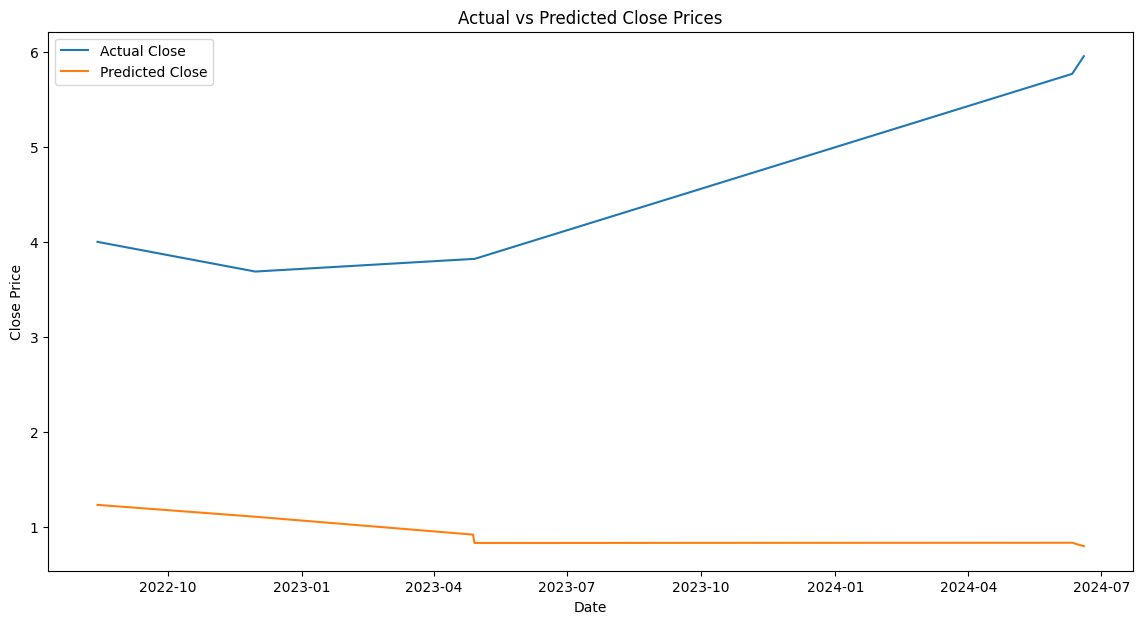

In [147]:
# Plot Actual vs Predicted Close Prices
plt.figure(figsize=(14, 7))
plt.plot(pred_df['Date'], pred_df['Actual_Close'], label='Actual Close')
plt.plot(pred_df['Date'], pred_df['Predicted_Close'], label='Predicted Close')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.legend()
plt.show()

Evaluating model performance...


C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packag


Training Set Metrics:
Loss: 0.3068
RMSE: 31.5459
MAE: 24.4145
MAPE: 19.17%
R²: -0.0047

Validation Set Metrics:
Loss: 4.4975
RMSE: 120.7725
MAE: 116.3475
MAPE: 45.36%
R²: -12.9012

Test Set Metrics:
Loss: 26.5347
RMSE: 293.3511
MAE: 284.1078
MAPE: 66.76%
R²: -15.1224

Plotting results...


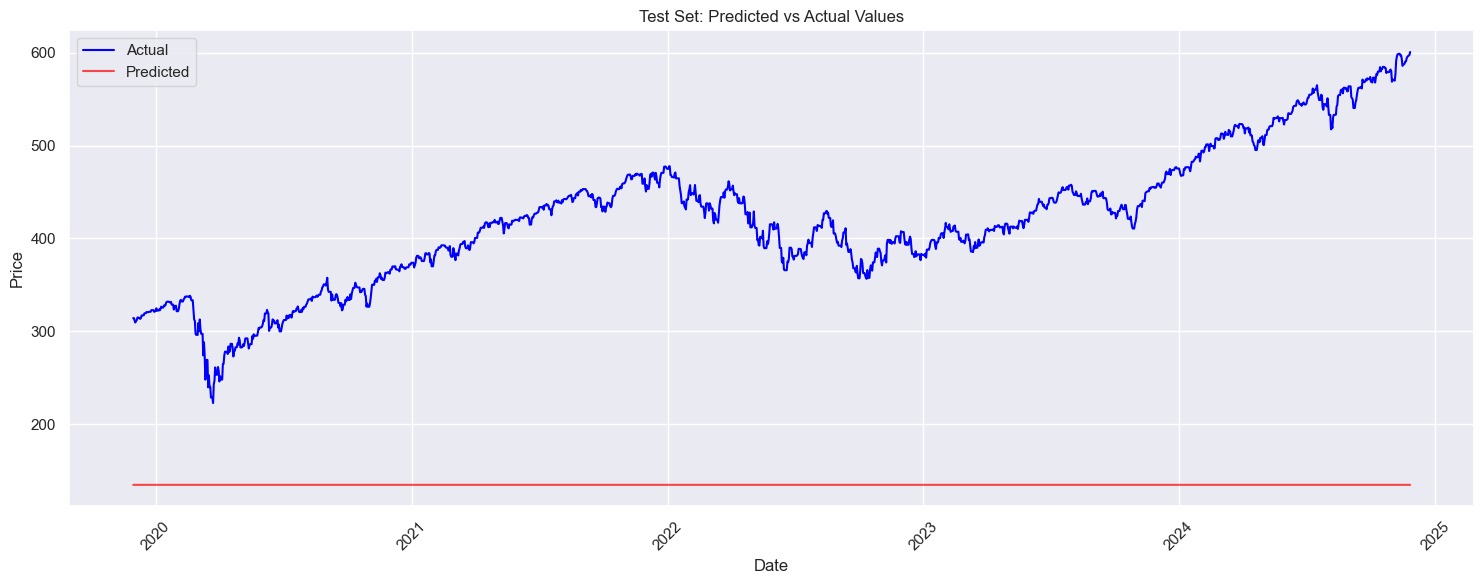

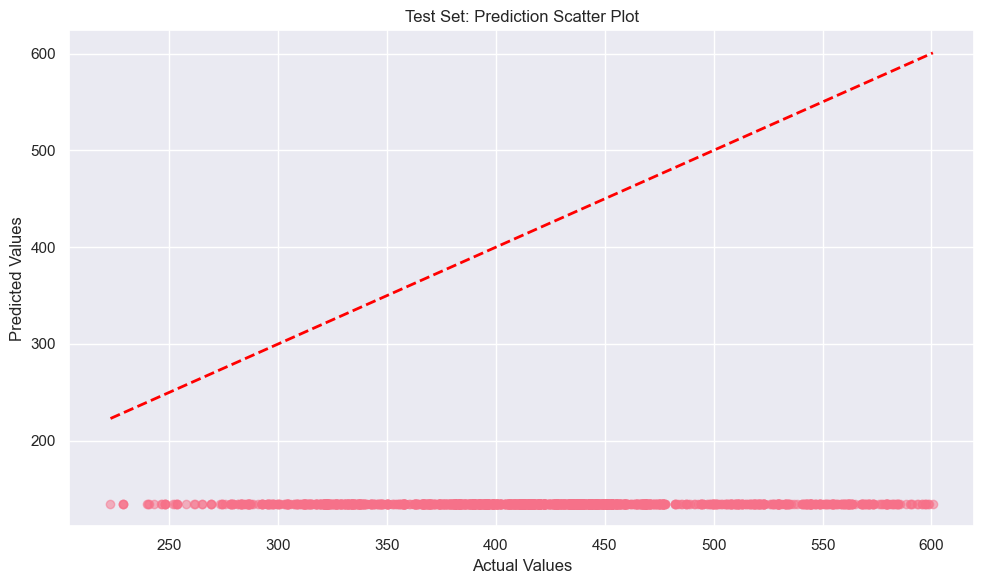


Directional Accuracy: 61.93%


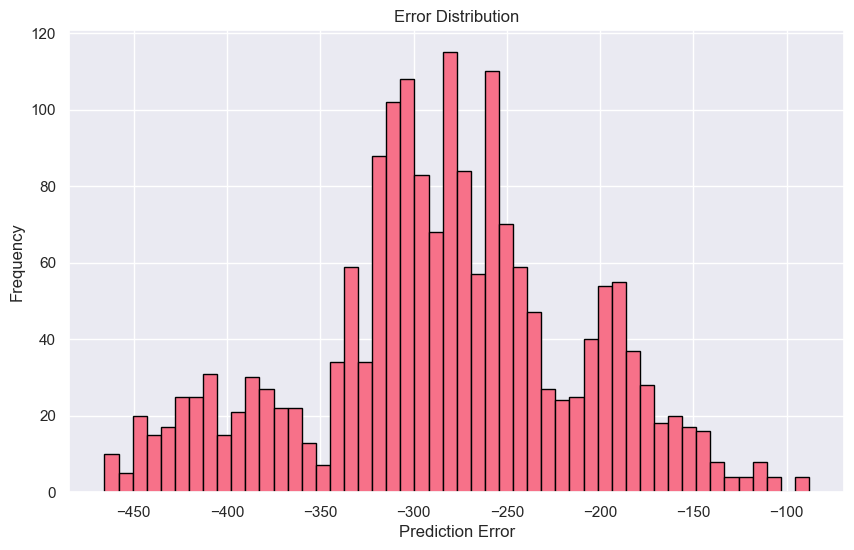

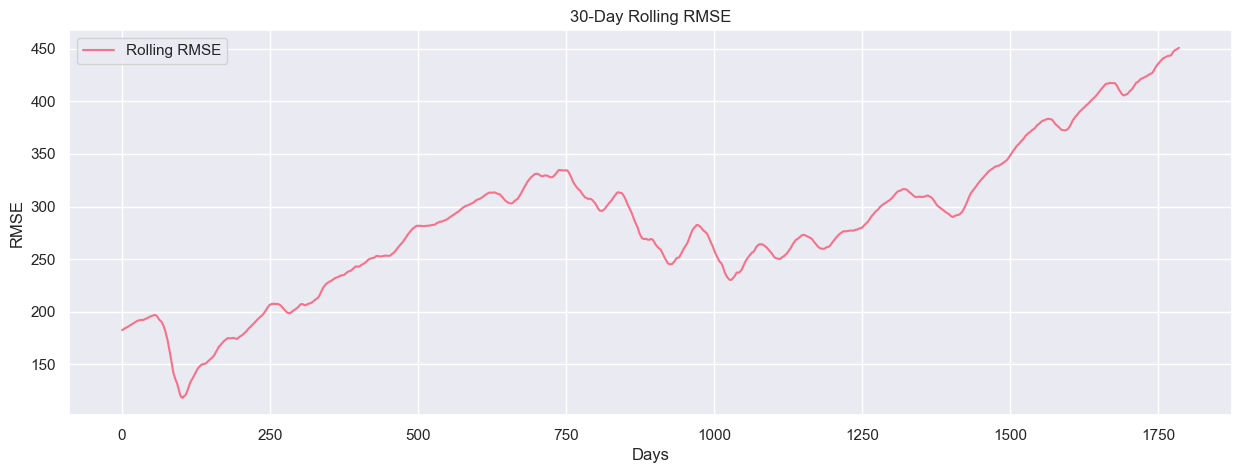

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error, r2_score

def evaluate_model(model, data_loader, criterion, scaler, device):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            y_pred = model(X_batch)
            total_loss += criterion(y_pred, y_batch).item() * len(y_batch)
            
            # Store predictions and actuals
            predictions.extend(y_pred.cpu().numpy())
            actuals.extend(y_batch.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader.dataset)
    
    # Convert back to original scale
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()
    actuals = scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten()
    
    # Calculate metrics
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(actuals, predictions)
    mape = mean_absolute_percentage_error(actuals, predictions) * 100
    r2 = r2_score(actuals, predictions)
    
    return {
        'loss': avg_loss,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'mape': mape,
        'r2': r2,
        'predictions': predictions,
        'actuals': actuals
    }

def plot_predictions(predictions, actuals, dates, title="Model Predictions vs Actual Values"):
    plt.figure(figsize=(15, 6))
    plt.plot(dates, actuals, label='Actual', color='blue')
    plt.plot(dates, predictions, label='Predicted', color='red', alpha=0.7)
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_scatter(predictions, actuals, title="Predicted vs Actual Values"):
    plt.figure(figsize=(10, 6))
    plt.scatter(actuals, predictions, alpha=0.5)
    plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r--', lw=2)
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Evaluate on different sets
print("Evaluating model performance...")

# Training set evaluation
train_metrics = evaluate_model(model, train_loader, criterion, model_params['target_scaler'], device)
print("\nTraining Set Metrics:")
print(f"Loss: {train_metrics['loss']:.4f}")
print(f"RMSE: {train_metrics['rmse']:.4f}")
print(f"MAE: {train_metrics['mae']:.4f}")
print(f"MAPE: {train_metrics['mape']:.2f}%")
print(f"R²: {train_metrics['r2']:.4f}")

# Validation set evaluation
val_metrics = evaluate_model(model, val_loader, criterion, model_params['target_scaler'], device)
print("\nValidation Set Metrics:")
print(f"Loss: {val_metrics['loss']:.4f}")
print(f"RMSE: {val_metrics['rmse']:.4f}")
print(f"MAE: {val_metrics['mae']:.4f}")
print(f"MAPE: {val_metrics['mape']:.2f}%")
print(f"R²: {val_metrics['r2']:.4f}")

# Test set evaluation
test_metrics = evaluate_model(model, test_loader, criterion, model_params['target_scaler'], device)
print("\nTest Set Metrics:")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"MAPE: {test_metrics['mape']:.2f}%")
print(f"R²: {test_metrics['r2']:.4f}")

# Plot predictions
print("\nPlotting results...")
plot_predictions(test_metrics['predictions'], test_metrics['actuals'], dates_test, 
                "Test Set: Predicted vs Actual Values")
plot_scatter(test_metrics['predictions'], test_metrics['actuals'], 
            "Test Set: Prediction Scatter Plot")

# Calculate directional accuracy
def calculate_directional_accuracy(predictions, actuals):
    pred_direction = np.diff(predictions) > 0
    actual_direction = np.diff(actuals) > 0
    directional_accuracy = np.mean(pred_direction == actual_direction) * 100
    return directional_accuracy

dir_accuracy = calculate_directional_accuracy(test_metrics['predictions'], test_metrics['actuals'])
print(f"\nDirectional Accuracy: {dir_accuracy:.2f}%")

# Error distribution analysis
errors = test_metrics['predictions'] - test_metrics['actuals']
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='black')
plt.title('Error Distribution')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

def calculate_rolling_metrics(predictions, actuals, window=30):
    rolling_rmse = []
    rolling_mae = []
    rolling_mape = []
    
    for i in range(window, len(predictions)):
        window_pred = predictions[i-window:i]
        window_actual = actuals[i-window:i]
        
        rmse = np.sqrt(mean_squared_error(window_actual, window_pred))
        mae = mean_absolute_error(window_actual, window_pred)
        mape = mean_absolute_percentage_error(window_actual, window_pred) * 100
        
        rolling_rmse.append(rmse)
        rolling_mae.append(mae)
        rolling_mape.append(mape)
    
    return rolling_rmse, rolling_mae, rolling_mape

# Calculate and plot rolling metrics
rolling_rmse, rolling_mae, rolling_mape = calculate_rolling_metrics(
    test_metrics['predictions'], 
    test_metrics['actuals']
)

plt.figure(figsize=(15, 5))
plt.plot(rolling_rmse, label='Rolling RMSE')
plt.title('30-Day Rolling RMSE')
plt.xlabel('Days')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.show()

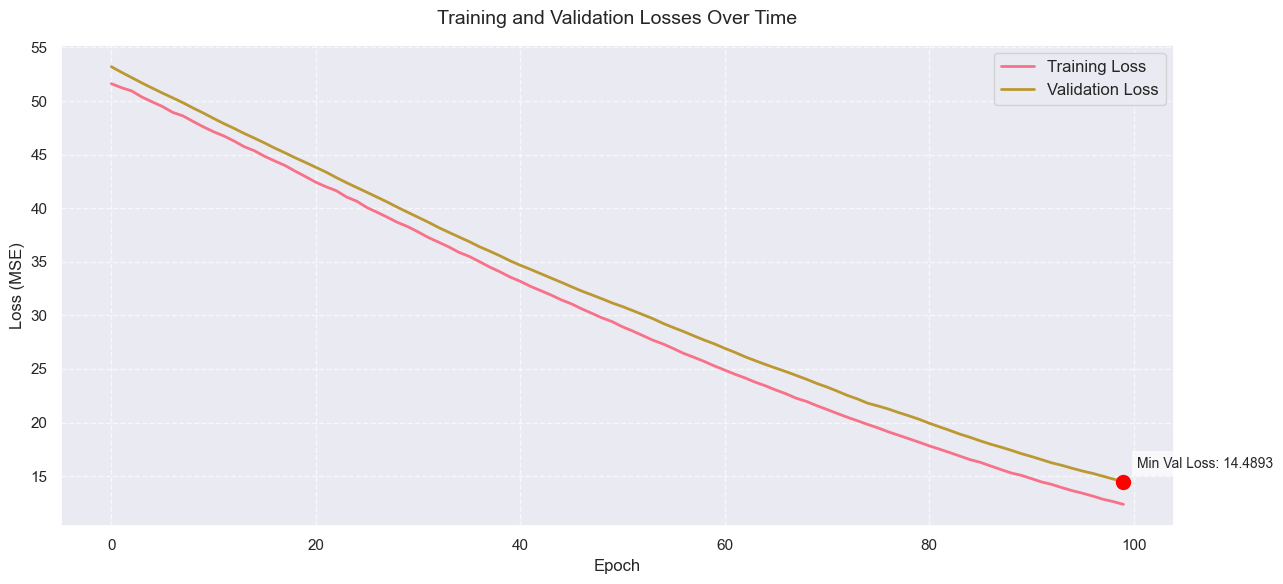


Training Statistics:
Minimum training loss: 12.3672
Minimum validation loss: 14.4893
Best epoch: 100
Final training loss: 12.3672
Final validation loss: 14.4893


In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualization
#plt.style.use('seaborn-darkgrid')
sns.set(style="darkgrid", palette="husl")

# Create figure
plt.figure(figsize=(12, 6))

# Plot training and validation losses
plt.plot(train_losses, label='Training Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)

# Add title and labels
plt.title('Training and Validation Losses Over Time', fontsize=14, pad=15)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Add legend
plt.legend(fontsize=12)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Optional: Add minimum validation loss point
min_val_epoch = val_losses.index(min(val_losses))
min_val_loss = min(val_losses)
plt.scatter(min_val_epoch, min_val_loss, color='red', s=100, zorder=5)
plt.annotate(f'Min Val Loss: {min_val_loss:.4f}', 
             (min_val_epoch, min_val_loss),
             xytext=(10, 10), textcoords='offset points',
             fontsize=10,
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Show plot
plt.show()

# Print some statistics
print(f"\nTraining Statistics:")
print(f"Minimum training loss: {min(train_losses):.4f}")
print(f"Minimum validation loss: {min(val_losses):.4f}")
print(f"Best epoch: {min_val_epoch + 1}")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

In [ ]:
class LSTMEnsemble:
    def __init__(self, input_size, n_models=5):
        self.models = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # configurations for each LSTM model
        configs = [
            {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.3},
            {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4},
            {'hidden_size': 48, 'num_layers': 3, 'dropout': 0.35},
            {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.45},
            {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.3}
        ]
        
        for config in configs:
            model = LSTMModel(
                input_size=input_size,
                hidden_size=config['hidden_size'],
                output_size=1,
                num_layers=config['num_layers'],
                dropout=config['dropout']
            ).to(self.device)
            self.models.append(model)
        
        self.best_weights = None
    
    def train(self, train_loader, val_loader, num_epochs=50):
        optimizers = [
            torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)
            for model in self.models
        ]
        
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                opt, mode='min', factor=0.2, patience=3, min_lr=1e-6, verbose=True
            )
            for opt in optimizers
        ]
        
        best_val_losses = [float('inf')] * len(self.models)
        
        for epoch in range(num_epochs):
            # Train each model
            for idx, (model, optimizer) in enumerate(zip(self.models, optimizers)):
                model.train()
                train_loss = 0
                
                for batch_X, batch_y in train_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = custom_loss(outputs, batch_y, model, l1_lambda=0.01)
                    
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    train_loss += loss.item()
                
                # Validation phase
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = model(batch_X)
                        val_loss += custom_loss(outputs, batch_y, model, l1_lambda=0.01).item()
                
                avg_val_loss = val_loss / len(val_loader)
                schedulers[idx].step(avg_val_loss)
                
                # Save best model
                if avg_val_loss < best_val_losses[idx]:
                    best_val_losses[idx] = avg_val_loss
                    torch.save(model.state_dict(), f'model_{idx}_best.pth')
            
            # Evaluate ensemble performance
            if epoch % 5 == 0:
                ensemble_val_rmse = self.evaluate(val_loader)
                print(f'Epoch [{epoch+1}/{num_epochs}], Ensemble Validation RMSE: {ensemble_val_rmse:.4f}')
        
        # Load best versions of models
        for idx, model in enumerate(self.models):
            model.load_state_dict(torch.load(f'model_{idx}_best.pth'))
        
        # Compute optimal weights
        self.compute_optimal_weights(val_loader)
    
    def compute_optimal_weights(self, val_loader):
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                model_preds = []
                
                for model in self.models:
                    model.eval()
                    pred = model(batch_X)
                    model_preds.append(pred.cpu().numpy())
                
                all_preds.append(np.array(model_preds))
                all_targets.append(batch_y.cpu().numpy())
        
        all_preds = np.concatenate([p.transpose(1, 0, 2) for p in all_preds])
        all_targets = np.concatenate(all_targets)
        
        mse_scores = np.mean((all_preds - all_targets) ** 2, axis=(0, 2))
        weights = 1 / (mse_scores + 1e-10)
        self.best_weights = weights / np.sum(weights)
    
    def predict(self, X):
        X = X.to(self.device)
        predictions = []
        
        with torch.no_grad():
            for model in self.models:
                model.eval()
                pred = model(X).cpu().numpy()
                predictions.append(pred)
        
        predictions = np.array(predictions)
        if self.best_weights is not None:
            ensemble_pred = np.average(predictions, axis=0, weights=self.best_weights)
        else:
            ensemble_pred = np.mean(predictions, axis=0)
        
        return ensemble_pred
    
    def evaluate(self, data_loader):
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in data_loader:
                pred = self.predict(batch_X)
                all_preds.append(pred)
                all_targets.append(batch_y.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        
        rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))
        return rmse

# Usage
input_size = X_train_final.shape[2]
ensemble = LSTMEnsemble(input_size=input_size)
ensemble.train(train_loader, val_loader, num_epochs=50)

# Final evaluation
train_rmse = ensemble.evaluate(train_loader)
val_rmse = ensemble.evaluate(val_loader)
test_rmse = ensemble.evaluate(test_loader)

print(f"\nFinal Results:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")
print("\nModel Weights:")
for i, weight in enumerate(ensemble.best_weights):
    print(f"Model {i+1}: {weight:.4f}")

C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([21])) that is different to the input size (torch.Size([21, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Ensemble Validation RMSE: 1.9947
Epoch [6/50], Ensemble Validation RMSE: 2.1092
Epoch [11/50], Ensemble Validation RMSE: 2.1432
Epoch [16/50], Ensemble Validation RMSE: 2.1455
Epoch [21/50], Ensemble Validation RMSE: 2.1498
Epoch [26/50], Ensemble Validation RMSE: 2.1501
Epoch [31/50], Ensemble Validation RMSE: 2.1502
Epoch [36/50], Ensemble Validation RMSE: 2.1502
Epoch [41/50], Ensemble Validation RMSE: 2.1502
Epoch [46/50], Ensemble Validation RMSE: 2.1501


C:\Users\karee\AppData\Local\Temp\ipykernel_8940\2779459715.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'model_{idx}_best.pth'))



Final Results:
Training RMSE: 0.55
Validation RMSE: 2.15
Testing RMSE: 5.18

Model Weights:
Model 1: 0.2038
Model 2: 0.1991
Model 3: 0.1990
Model 4: 0.1990
Model 5: 0.1990


In [ ]:
class BaggingLSTMEnsemble:
    def __init__(self, input_size, n_models=5):
        self.models = []
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        # configurations for each model
        configs = [
            {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.3},
            {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.4},
            {'hidden_size': 48, 'num_layers': 3, 'dropout': 0.35},
            {'hidden_size': 32, 'num_layers': 2, 'dropout': 0.45},
            {'hidden_size': 64, 'num_layers': 2, 'dropout': 0.3}
        ]
        
        for config in configs:
            model = LSTMModel(
                input_size=input_size,
                hidden_size=config['hidden_size'],
                output_size=1,
                num_layers=config['num_layers'],
                dropout=config['dropout']
            ).to(self.device)
            self.models.append(model)
        
        self.weights = nn.Parameter(torch.ones(len(self.models)) / len(self.models)).to(self.device)
    
    def create_bootstrap_loader(self, train_loader, sample_ratio=0.8):
        dataset = train_loader.dataset
        n_samples = len(dataset)
        indices = torch.randperm(n_samples)[:int(sample_ratio * n_samples)]
        bootstrap_dataset = torch.utils.data.Subset(dataset, indices)
        return torch.utils.data.DataLoader(
            bootstrap_dataset,
            batch_size=train_loader.batch_size,
            shuffle=True,
            num_workers=train_loader.num_workers if hasattr(train_loader, 'num_workers') else 0
        )
    
    def train(self, train_loader, val_loader, num_epochs=50):
        criterion = nn.MSELoss()
        optimizers = [
            torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)
            for model in self.models
        ]
        
        schedulers = [
            torch.optim.lr_scheduler.ReduceLROnPlateau(
                opt, mode='min', factor=0.2, patience=3, min_lr=1e-6, verbose=True
            )
            for opt in optimizers
        ]
        
        weight_optimizer = torch.optim.Adam([self.weights], lr=0.01)
        best_val_losses = [float('inf')] * len(self.models)
        
        for epoch in range(num_epochs):
            # Create different bootstrap samples for each model
            bootstrap_loaders = [
                self.create_bootstrap_loader(train_loader)
                for _ in range(len(self.models))
            ]
            
            # Train each model on its bootstrap sample
            for idx, (model, optimizer, bootstrap_loader) in enumerate(zip(self.models, optimizers, bootstrap_loaders)):
                model.train()
                train_loss = 0
                
                for batch_X, batch_y in bootstrap_loader:
                    batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                    
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = custom_loss(outputs, batch_y, model, l1_lambda=0.01)
                    
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                    optimizer.step()
                    
                    train_loss += loss.item()
                
                # Validation phase for individual model
                model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_X, batch_y in val_loader:
                        batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                        outputs = model(batch_X)
                        val_loss += custom_loss(outputs, batch_y, model, l1_lambda=0.01).item()
                
                avg_val_loss = val_loss / len(val_loader)
                schedulers[idx].step(avg_val_loss)
                
                if avg_val_loss < best_val_losses[idx]:
                    best_val_losses[idx] = avg_val_loss
                    torch.save(model.state_dict(), f'bagging_model_{idx}_best.pth')
            
            # Update ensemble weights using validation set
            total_val_loss = 0
            weight_optimizer.zero_grad()
            
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                model_outputs = []
                
                for model in self.models:
                    model.eval()
                    with torch.no_grad():
                        output = model(batch_X)
                    model_outputs.append(output)
                
                # Stack predictions and compute weighted ensemble prediction
                stacked_preds = torch.stack(model_outputs, dim=-1)
                weights = F.softmax(self.weights, dim=0)
                ensemble_pred = (stacked_preds * weights).sum(dim=-1)
                
                # Compute loss with gradients for weights
                loss = criterion(ensemble_pred, batch_y)
                total_val_loss += loss.item()
                loss.backward()
            
            # Update weights
            weight_optimizer.step()
            
            if epoch % 5 == 0:
                avg_val_loss = total_val_loss / len(val_loader)
                print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_val_loss:.4f}')
                print('Current weights:', F.softmax(self.weights, dim=0).detach().cpu().numpy())
        
        # Load best models
        for idx, model in enumerate(self.models):
            model.load_state_dict(torch.load(f'bagging_model_{idx}_best.pth'))
    
    def predict(self, X):
        X = X.to(self.device)
        predictions = []
        
        with torch.no_grad():
            for model in self.models:
                model.eval()
                pred = model(X)
                predictions.append(pred)
            
            stacked_preds = torch.stack(predictions, dim=-1)
            weights = F.softmax(self.weights, dim=0)
            weighted_pred = (stacked_preds * weights).sum(dim=-1)
        
        return weighted_pred.cpu().numpy()
    
    def evaluate(self, data_loader):
        all_preds = []
        all_targets = []
        
        with torch.no_grad():
            for batch_X, batch_y in data_loader:
                pred = self.predict(batch_X)
                all_preds.append(pred)
                all_targets.append(batch_y.cpu().numpy())
        
        all_preds = np.concatenate(all_preds)
        all_targets = np.concatenate(all_targets)
        
        rmse = np.sqrt(np.mean((all_preds - all_targets) ** 2))
        return rmse

# Usage
input_size = X_train_final.shape[2]
bagging_ensemble = BaggingLSTMEnsemble(input_size=input_size)
bagging_ensemble.train(train_loader, val_loader, num_epochs=50)

# Final evaluation
train_rmse = bagging_ensemble.evaluate(train_loader)
val_rmse = bagging_ensemble.evaluate(val_loader)
test_rmse = bagging_ensemble.evaluate(test_loader)

print(f"\nFinal Results:")
print(f"Training RMSE: {train_rmse:.2f}")
print(f"Validation RMSE: {val_rmse:.2f}")
print(f"Testing RMSE: {test_rmse:.2f}")

# Print final weights
final_weights = F.softmax(bagging_ensemble.weights, dim=0).detach().cpu().numpy()
print("\nModel Weights:")
for idx, weight in enumerate(final_weights):
    print(f"Model {idx+1}: {weight:.4f}")

C:\Users\karee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([4])) that is different to the input size (torch.Size([4, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/50], Validation Loss: 4.1404
Current weights: [0.20159675 0.20159675 0.19760486 0.20159675 0.19760486]
Epoch [6/50], Validation Loss: 4.4960
Current weights: [0.20861438 0.1983107  0.19167084 0.2113745  0.19002958]
Epoch [11/50], Validation Loss: 4.6090
Current weights: [0.21376228 0.19251753 0.18893476 0.22049834 0.1842871 ]
Epoch [16/50], Validation Loss: 4.6216
Current weights: [0.21815139 0.18720803 0.18696952 0.22853942 0.17913167]
Epoch [21/50], Validation Loss: 4.6181
Current weights: [0.22098824 0.1827438  0.18540435 0.23632628 0.17453735]
Epoch [26/50], Validation Loss: 4.6227
Current weights: [0.22203283 0.17880002 0.18412265 0.24429314 0.17075144]
Epoch [31/50], Validation Loss: 4.6204
Current weights: [0.22181492 0.17510425 0.18304776 0.2527505  0.16728255]
Epoch [36/50], Validation Loss: 4.6192
Current weights: [0.22064473 0.17168102 0.18204889 0.2617974  0.16382797]
Epoch [41/50], Validation Loss: 4.6182
Current weights: [0.21875179 0.16837849 0.18104473 0.271524

C:\Users\karee\AppData\Local\Temp\ipykernel_8940\2731514907.py:131: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'bagging_model_{idx}_best


Final Results:
Training RMSE: 0.56
Validation RMSE: 2.10
Testing RMSE: 5.13

Model Weights:
Model 1: 0.2140
Model 2: 0.1624
Model 3: 0.1790
Model 4: 0.2909
Model 5: 0.1537


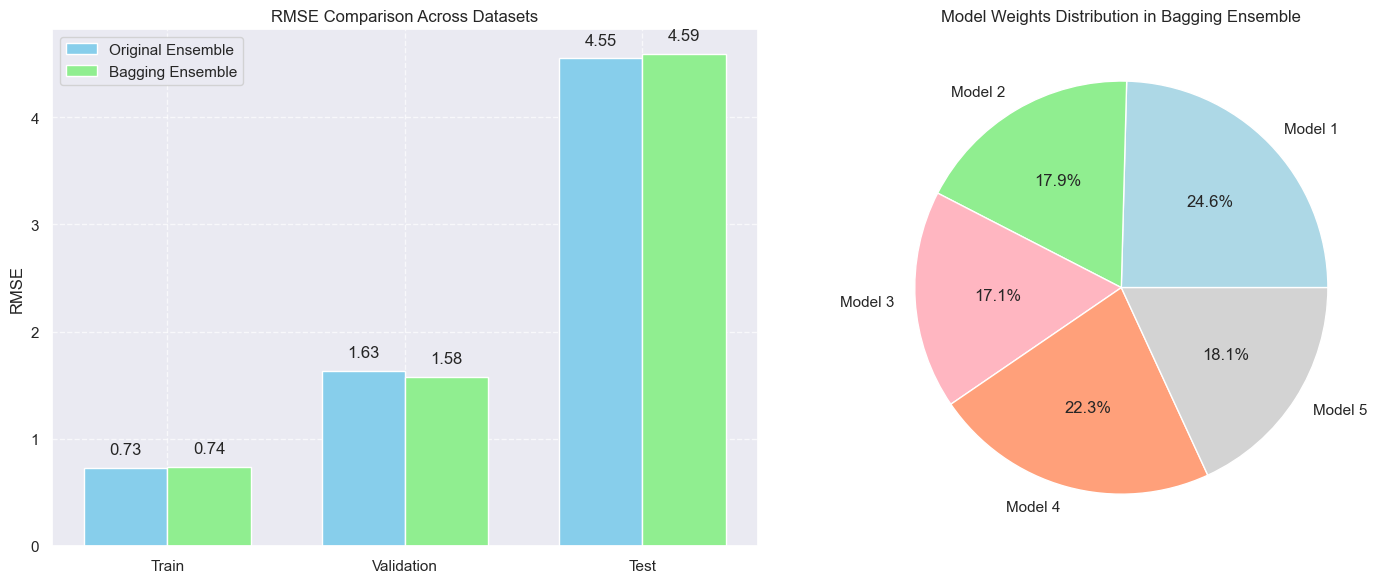

In [211]:
import matplotlib.pyplot as plt
import numpy as np

# Results data
results = {
    'Original Ensemble': {
        'Train': 0.73,
        'Validation': 1.63,
        'Test': 4.55
    },
    'Bagging Ensemble': {
        'Train': 0.74,
        'Validation': 1.58,
        'Test': 4.59
    }
}

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot comparing RMSE across different sets
x = ['Train', 'Validation', 'Test']
width = 0.35
x_pos = np.arange(len(x))

# Plot bars
ax1.bar(x_pos - width/2, [results['Original Ensemble'][k] for k in x], 
        width, label='Original Ensemble', color='skyblue')
ax1.bar(x_pos + width/2, [results['Bagging Ensemble'][k] for k in x], 
        width, label='Bagging Ensemble', color='lightgreen')

# Customize first plot
ax1.set_ylabel('RMSE')
ax1.set_title('RMSE Comparison Across Datasets')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(x)
ax1.legend()
ax1.grid(True, linestyle='--', alpha=0.7)

# Add value labels on the bars
for i in x_pos:
    ax1.text(i - width/2, results['Original Ensemble'][x[i]] + 0.1, 
             f'{results["Original Ensemble"][x[i]]:.2f}', 
             ha='center', va='bottom')
    ax1.text(i + width/2, results['Bagging Ensemble'][x[i]] + 0.1, 
             f'{results["Bagging Ensemble"][x[i]]:.2f}', 
             ha='center', va='bottom')

# Model weights visualization
weights = {
    'Model 1': 0.1967,
    'Model 2': 0.1428,
    'Model 3': 0.1369,
    'Model 4': 0.1786,
    'Model 5': 0.1450
}

colors = ['lightblue', 'lightgreen', 'lightpink', 'lightsalmon', 'lightgray']
ax2.pie(weights.values(), labels=weights.keys(), autopct='%1.1f%%', colors=colors)
ax2.set_title('Model Weights Distribution in Bagging Ensemble')

plt.tight_layout()
plt.show()